In [1]:
import os
import cv2
import shutil
import deeplabcut
import numpy as np
import pandas as pd
import subprocess
from datetime import date
import time
import math
from joblib import Parallel, delayed
import glob
from skimage import feature, measure
import requests
import argparse
from matplotlib import pyplot as plt
from scipy.linalg import fractional_matrix_power
import scipy.stats as stats

2024-01-16 18:19:17.867288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 18:19:17.977382: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 18:19:18.023935: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 18:19:18.425501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dler

Loading DLC 2.3.5...


In [2]:
def notify(message):
    token = "6526533628:AAEtX7wC6BmrFGveQdkTifeKvc0m_iCMNRQ"
    url = f"https://api.telegram.org/bot{token}"
    params = {"chat_id": "5665811216", "text": message}
    r = requests.get(url + "/sendMessage", params=params)

In [3]:
if not os.path.exists('Stats_Analysis_AGC'):
        os.makedirs('Stats_Analysis_AGC')
os.chdir('Stats_Analysis_AGC')

In [27]:
os.getcwd()

'/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids_2/GC_Conv_vids'

In [5]:
if not os.path.exists('All_vids'):
        os.makedirs('All_vids')
os.chdir('All_vids')

In [6]:
#enter path of folder (including folder name) containing all your videos of interest
vid_dir = '/home/yashas/Documents/dlc_projects/Videos_mac'
to_dir = os.path.join(os.getcwd(), os.path.basename(vid_dir))
# shutil.move(vid_dir, to_dir)

In [7]:
os.path.dirname(to_dir)

'/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids'

In [8]:
#Soring converted videos in a new folder
if not os.path.exists('Conv_vids'):
        os.makedirs('Conv_vids')

In [ ]:
input_file = '/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/Videos_mac/ken_20210503_0911_XBI19_reversal_learning_foraging_SC3_DCS_frontcamera.mov'
output_file = os.path.splitext(os.path.basename(input_file))[0].lstrip('.') 
os.path.dirname(os.path.dirname(input_file))
print(os.path.join(os.path.dirname(os.path.dirname(input_file)), '/Conv_vids', output_file +'_conv.mp4'))

In [ ]:
#Converting .mov videos to .mp4
def conv_mp4(input_file):
    out_name = os.path.splitext(input_file)[0].lstrip('.') 
    print(out_name)
    output_file = out_name + '.mp4'
    # print(input_file)
    # print(output_file)
    # Run FFmpeg command to convert MOV to MP4
    command = f"ffmpeg -i {input_file} -c:v libx264 -preset medium -crf 23 -c:a aac -b:a 128k {output_file}"
    subprocess.call(command, shell=True)
    new = os.path.join(os.path.dirname(os.path.dirname(output_file)), 'Conv_vids', os.path.basename(output_file))
    shutil.move(output_file, new)
    # print('Convertion complete - ', os.path.basename(output_file))

In [ ]:
for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'Videos_mac')):
    path=os.path.join(os.path.join(os.path.dirname(to_dir), 'Videos_mac', file))
    if file.endswith(".mov"):
        
        conv_mp4(path)
    else:
        new_path = os.path.join(os.path.join(os.path.dirname(to_dir), 'Conv_vids', file))
        shutil.copy(path, new_path)
        

In [29]:
if not os.path.exists('GC_Conv_vids'):
        os.makedirs('GC_Conv_vids')
os.chdir('GC_Conv_vids')

In [25]:
os.getcwd()

'/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/GC_Conv_vids'

In [ ]:
#os.listdir(os.path.join(os.path.dirname(to_dir), 'DSConv_vids'))
# os.path.join(os.path.dirname(to_dir), 'NDSConv_vids', os.path.basename(dsv)) 

In [26]:
#cropping video and Gamma correction
def downsize_gc(convid):
    # dsv = deeplabcut.DownSampleVideo(convid, width=320, height=240)
    dsv = convid
    # Load the video file
    video = cv2.VideoCapture(dsv)

    # Get the frame rate and total number of frames
    fps = int(video.get(cv2.CAP_PROP_FPS))
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    #*********************************************

    # Set the start and end points to crop out
    start_sec = 0  # Crop out the first x seconds
    end_sec = 0 # Crop out the last y seconds

    #Set gamma correction value
    gamma = 2

    #**********************************************

    start_frame = int(start_sec * fps)
    end_frame = int((total_frames / fps) - end_sec) * fps

    # Set the video writer
    output_name = os.path.splitext(os.path.basename(convid))[0].lstrip('.') + '_GC.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_name, fourcc, fps, (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))))

    # Set the current frame number to the start frame
    video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    frame_number = 0

    # Loop through the frames and write them to the output video
    for i in range(start_frame, end_frame):
        ret, frame = video.read()
        if not ret:
            break

        # Normalize the pixel values to the range [0, 1]
        frame_normalized = frame.astype(np.float32) / 255.0

        # Apply gamma correction
        frame_corrected = np.power(frame_normalized, 1/gamma)

        # Scale the pixel values back to the range [0, 255]
        frame_scaled = (frame_corrected * 255.0).astype(np.uint8)

        out.write(frame_scaled)
        print(round(frame_number/total_frames*100, 2), end = '\r')
        frame_number += 1
    new = os.path.join(os.path.dirname(os.path.dirname(dsv)), 'GC_Conv_vids', os.path.basename(dsv))
    shutil.move(dsv, new)

    # Release the video objects
    video.release()
    out.release()
    cv2.destroyAllWindows()
    print("Done - ", convid)
    print('')

In [ ]:
for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'Conv_vids')):
    if file.endswith(".mp4"):
        path=os.path.join(os.path.join(os.path.dirname(to_dir), 'Conv_vids', file))
        downsize_gc(path)

In [ ]:
# def image_agcwd(img, a=0.25, truncated_cdf=False):
#     h,w = img.shape[:2]
#     hist,bins = np.histogram(img.flatten(),256,[0,256])
#     cdf = hist.cumsum()
#     cdf_normalized = cdf / cdf.max()
#     prob_normalized = hist / hist.sum()

#     unique_intensity = np.unique(img)
#     intensity_max = unique_intensity.max()
#     intensity_min = unique_intensity.min()
#     prob_min = prob_normalized.min()
#     prob_max = prob_normalized.max()
    
#     pn_temp = (prob_normalized - prob_min) / (prob_max - prob_min)
#     pn_temp[pn_temp>0] = prob_max * (pn_temp[pn_temp>0]**a)
#     pn_temp[pn_temp<0] = prob_max * (-((-pn_temp[pn_temp<0])**a))
#     prob_normalized_wd = pn_temp / pn_temp.sum() # normalize to [0,1]
#     cdf_prob_normalized_wd = prob_normalized_wd.cumsum()
    
#     if truncated_cdf: 
#         inverse_cdf = np.maximum(0.5,1 - cdf_prob_normalized_wd)
#     else:
#         inverse_cdf = 1 - cdf_prob_normalized_wd
    
#     img_new = img.copy()
#     for i in unique_intensity:
#         img_new[img==i] = np.round(255 * (i / 255)**inverse_cdf[i])
   
#     return img_new

# def process_bright(img):
#     img_negative = 255 - img
#     agcwd = image_agcwd(img_negative, a=0.25, truncated_cdf=False)
#     reversed = 255 - agcwd
#     return reversed

# def process_dimmed(img):
#     agcwd = image_agcwd(img, a=0.75, truncated_cdf=True)
#     return agcwd

# # def main():
# #     parser = argparse.ArgumentParser(description='IAGCWD')
# #     parser.add_argument('--input', dest='input_dir', default='./input/', type=str, \
# #                         help='Input directory for image(s)')
# #     parser.add_argument('--output', dest='output_dir', default='./output/', type=str, \
# #                         help='Output directory for image(s)')
# #     args = parser.parse_args()
    
# #     img_paths = glob.glob(args.input_dir+'*')
# #     for path in img_paths:
# #         img = cv2.imread(path, 1)

# # name = path.split('\\')[-1].split('.')[0]
# # img = frame

# # # Extract intensity component of the image
# # YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
# # Y = YCrCb[:,:,0]
# # # Determine whether image is bright or dimmed
# # threshold = 0.3
# # exp_in = 112 # Expected global average intensity 
# # M,N = img.shape[:2]
# # mean_in = np.sum(Y/(M*N)) 
# # t = (mean_in - exp_in)/ exp_in

# # # Process image for gamma correction
# # img_output = None
# # if t < -threshold: # Dimmed Image
# #     print (name + ": Dimmed")
# #     result = process_dimmed(Y)
# #     YCrCb[:,:,0] = result
# #     img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
# # elif t > threshold:
# #     print (name + ": Bright Image") # Bright Image
# #     result = process_bright(Y)
# #     YCrCb[:,:,0] = result
# #     img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
# # else:
# #     img_output = img

# # cv2.imwrite(args.output_dir+name+'.jpg', img_output)

# # # if __name__ == '__main__':
# # #     main()

# #cropping video and Gamma correction
# def adap_gamma_correct(convid):
    
#     # Load the video file
#     video = cv2.VideoCapture(convid)

#     # Get the frame rate and total number of frames
#     fps = int(video.get(cv2.CAP_PROP_FPS))
#     total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# #     #*********************************************

# #     target_br = 0.68
# #     target_g = math.log(target_br)

# #     #**********************************************

#     # Set the video writer
#     output_name = os.path.splitext(os.path.basename(convid))[0].lstrip('.') + '_AGC.mp4'
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     out = cv2.VideoWriter(output_name, fourcc, fps, (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))))
#     start_frame = 0
#     # Set the current frame number to the start frame
#     video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
#     frame_number = 0
#     # Loop through the frames and write them to the output video
#     for i in range(start_frame, total_frames):
#         ret, frame = video.read()
#         if not ret:
#             break
            
# #         fr_size = frame.shape
# #         roi_h = [int(fr_size[0]/4), int(3*fr_size[0]/4)]
# #         roi_w = [int(fr_size[1]/3), int(2*fr_size[1]/3)]
# #         frame_roi = frame[roi_h[0]:roi_h[1], roi_w[0]:roi_w[1]]
        
# #         # cv2.imshow('output', frame)

# #         frame_normalized = frame.astype(np.float32) / 255.0
# #         frame_normalized_roi = frame_roi.astype(np.float32) / 255.0

# #         gray = cv2.cvtColor(frame_normalized_roi, cv2.COLOR_BGR2GRAY)
# #         # gray2 = cv2.cvtColor(frame_normalized, cv2.COLOR_BGR2GRAY)

# #         brightness = np.mean(frame_normalized_roi)
# #         # brightness2 = np.mean(frame_normalized)
        
        
# #         # frame_normalized = frame.astype(np.float32) / 255.0
# #         # gray = cv2.cvtColor(frame_normalized, cv2.COLOR_BGR2GRAY)
        
# #         # brightness = np.mean(frame_normalized)
# #         #finding and correcting gamma - a number is assigned to be the 'innate' gamma value of the frame, and that value is used to find the correction needed. 
# #         if brightness == 0:
# #             # cv2.imshow('output', frame)
# #             print(brightness, ' - err')
# #             continue
# #         assigned_g = math.log(brightness)
# #         gamma = assigned_g/target_g
        
# #         # Normalize the pixel values to the range [0, 1]
# #         # frame_normalized = frame.astype(np.float32) / 255.0

# #         # Apply gamma correction
# #         frame_corrected = np.power(frame_normalized, 1/gamma)

# #         # Scale the pixel values back to the range [0, 255]
# #         frame_scaled = (frame_corrected * 255.0).astype(np.uint8)
        
#         # name = path.split('\\')[-1].split('.')[0]

#         # Extract intensity component of the image
#         YCrCb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
#         Y = YCrCb[:,:,0]
#         # Determine whether image is bright or dimmed
#         threshold = 0.4
#         exp_in = 190 # Expected global average intensity 
#         M,N = frame.shape[:2]
#         mean_in = np.sum(Y/(M*N)) 
#         t = (mean_in - exp_in)/ exp_in

#         # Process image for gamma correction
#         img_output = None
#         if t < -threshold: # Dimmed Image
#             # print (name + ": Dimmed")
#             result = process_dimmed(Y)
#             YCrCb[:,:,0] = result
#             img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
#         elif t > threshold:
#             # print (name + ": Bright Image") # Bright Image
#             result = process_bright(Y)
#             YCrCb[:,:,0] = result
#             img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
#         else:
#             img_output = frame

#         out.write(img_output)
        
#         print(round(frame_number/total_frames*100, 2), end = '\r')
#         frame_number += 1
#         # cv2.imshow('output', frame)
#         # cv2.imshow('output', frame_scaled)
#         # out.write(frame_scaled)
#     # new = os.path.join(os.path.dirname(os.path.dirname(convid)), 'GC_Conv_vids', os.path.basename(convid))
#     # shutil.move(dsv, new)
#     print("Done - ", convid)
#     print('')
#     # Release the video objects
#     video.release()
#     out.release()
#     cv2.destroyAllWindows()

In [ ]:
# assert img is not None, "file could not be read, check with os.path.exists()"
# # create a CLAHE object (Arguments are optional).
# clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# cl1 = clahe.apply(img)

In [ ]:
# #cropping video and Gamma correction
# def adap_gamma_correct(convid):
    
#     # Load the video file
#     video = cv2.VideoCapture(convid)

#     # Get the frame rate and total number of frames
#     fps = int(video.get(cv2.CAP_PROP_FPS))
#     total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

#     #*********************************************

#     target_br = 0.72
#     target_g = math.log(target_br)

#     #**********************************************

#     # Set the video writer
#     output_name = os.path.splitext(os.path.basename(convid))[0].lstrip('.') + '_AGC_clahe.mp4'
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     out = cv2.VideoWriter(output_name, fourcc, fps, (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))))
#     start_frame = 0
#     # Set the current frame number to the start frame
#     video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
#     frame_number = 0
#     # Loop through the frames and write them to the output video
#     for i in range(start_frame, total_frames):
#         ret, frame = video.read()
#         if not ret:
#             break
        
#         lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
                
#         clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
#         lab[...,0] = clahe.apply(lab[...,0])
        
#         frame_scaled_edt = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        
        
#         frame_normalized = frame_scaled_edt.astype(np.float32) / 255.0
#         gray = cv2.cvtColor(frame_normalized, cv2.COLOR_BGR2GRAY)
        
#         brightness = np.mean(frame_normalized)
        
#         #finding and correcting gamma - a number is assigned to be the 'innate' gamma value of the frame, and that value is used to find the correction needed. 
#         if brightness == 0:
#             # cv2.imshow('output', frame)
#             print(brightness, ' - err')
#             continue
#         assigned_g = math.log(brightness)
#         gamma = assigned_g/target_g
        
#         # Apply gamma correction
#         frame_corrected = np.power(frame_normalized, 1/gamma)

#         # Scale the pixel values back to the range [0, 255]
#         frame_scaled = (frame_corrected * 255.0).astype(np.uint8)        
        
#         print(round(frame_number/total_frames*100, 2), end = '\r')
#         frame_number += 1
#         # cv2.imshow('output', frame)
#         # cv2.imshow('output', frame_scaled)
#         out.write(frame_scaled_edt)
#     # new = os.path.join(os.path.dirname(os.path.dirname(convid)), 'GC_Conv_vids', os.path.basename(convid))
#     # shutil.move(dsv, new)
#     print("Done - ", convid)
#     print('')
#     # Release the video objects
#     video.release()
#     out.release()
#     cv2.destroyAllWindows()

In [ ]:
# #cropping video and Gamma correction
# def adap_gamma_correct(convid, tbr, clp, gs):
    
#     # Load the video file
#     video = cv2.VideoCapture(convid)

#     # Get the frame rate and total number of frames
#     # fps = int(video.get(cv2.CAP_PROP_FPS))
#     fps = 30
#     total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
#     print(total_frames)

#     #*********************************************

#     # target_br = 0.72
#     target_br = tbr
#     target_g = math.log(target_br)
#     # gs = 4
#     gs_w, gs_h = gs

#     #**********************************************

#     # Set the video writer
#     output_name = os.path.splitext(os.path.basename(convid))[0].lstrip('.') + '_' + str(int(target_br*100)) + '_' + str(clp) + '_' + str(gs_w) + '_' + str(gs_h) + '_AGC_clahe.mp4'
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     out = cv2.VideoWriter(output_name, fourcc, fps, (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))))
#     start_frame = 0
#     # Set the current frame number to the start frame
#     video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
#     frame_number = 0
#     noted = 0
#     # Loop through the frames and write them to the output video
#     for i in range(start_frame, total_frames):
#         ret, frame = video.read()
#         if not ret:
#             break
        
#         lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
                
#         clahe = cv2.createCLAHE(clipLimit=clp, tileGridSize=(gs_w, gs_h))
#         lab[...,0] = clahe.apply(lab[...,0])
        
#         frame_scaled_edt = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        
        
#         frame_normalized = frame_scaled_edt.astype(np.float32) / 255.0
#         gray = cv2.cvtColor(frame_normalized, cv2.COLOR_BGR2GRAY)
        
#         brightness = np.mean(frame_normalized)
        
#         #finding and correcting gamma - a number is assigned to be the 'innate' gamma value of the frame, and that value is used to find the correction needed. 
#         if brightness == 0:
#             # cv2.imshow('output', frame)
#             print(brightness, ' - err')
#             continue
#         assigned_g = math.log(brightness)
#         gamma = assigned_g/target_g
        
#         # Apply gamma correction
#         frame_corrected = np.power(frame_normalized, 1/gamma)

#         # Scale the pixel values back to the range [0, 255]
#         frame_scaled = (frame_corrected * 255.0).astype(np.uint8)        

#         progress = frame_number/total_frames*100

#         # if progress%10==0:
            
        
#         # if noted==0:
#         #     noted = 1
#         #     # notify(progress)
#         # elif noted == 1:
#         #     noted = 0
#         print(round(progress, 2), noted, end = '\r')
#         frame_number += 1
#         # cv2.imshow('output', frame)
#         # cv2.imshow('output', frame_scaled)
#         out.write(frame_scaled)
#     # new = os.path.join(os.path.dirname(os.path.dirname(convid)), 'GC_Conv_vids', os.path.basename(convid))
#     # shutil.move(dsv, new)
#     # Release the video objects
#     video.release()
#     out.release()
#     cv2.destroyAllWindows()
#     print("Done - ", convid)
#     notify("Done - " + convid)
#     print('')

In [9]:
csvfile = '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/DLC-YR-2024-01-12/labeled-data/Comp_ngc/CollectedData_YR.csv'

man_lab = pd.read_csv(csvfile, header=[1,2])

man_lab = man_lab.rename(columns={'Unnamed: 2_level_0':'Frame_no', 'Unnamed: 2_level_1':''})

In [10]:
fr = man_lab['Frame_no']
# fr[1]
fr2ext = []
for i in fr:
# #     # fr2ext.append(int(i.split('.')[0].split('g')[1]))
    fr2ext.append(i)
#     # print(int(i.split('.')[0].split('g')[1]))
len(fr2ext)
# fr

14

In [44]:
if not os.path.exists('CP_Comp'):
        os.makedirs('CP_Comp')
os.chdir('CP_Comp')

In [98]:
clp_set = []
for tbr in range(70, 75, 1):
    for clp in range(0, 20, 2):
        for gs in range(2, 7, 1):
            clp_set.append([tbr/100, clp/10, gs, gs])

img_fold = '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/DLC-YR-2024-01-12/labeled-data/Comp_ngc/'

files2comp = []
for file in os.listdir(img_fold):
    if file in fr2ext:
        files2comp.append(os.path.join(img_fold, file))
files2comp = sorted(files2comp)


FileNotFoundError: [Errno 2] No such file or directory: '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/DLC-YR-2024-01-12/labeled-data/Comp_ngc/'

In [30]:
def compare_param(images, clp_set):
    
    total_frames = len(clp_set)
    total_images = len(images)
    
    total_runs = total_frames*total_images
    
    # target_br = tbr
    # target_g = math.log(target_br)
    # gs_w, gs_h = gs
    image_number = 0
    
    for fr in images:
        # output_name = os.path.splitext(os.path.basename(convid))[0].lstrip('.') + '_' + str(int(target_br*100)) + '_' + str(clp) + '_' + str(gs_w) + '_' + str(gs_h) + '_AGC_clahe.mp4'
        output_name = os.path.splitext(os.path.basename(fr))[0]+'.mp4'
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = 5
        out = cv2.VideoWriter(output_name, fourcc, fps, (320, 240))
        
        # Set the current frame number to the start frame
        frame_number = 0
    
        frame = cv2.imread(fr)

        out.write(frame)
    
        for i in clp_set:
            tbr, clp, gs = i
            target_br = tbr
            target_g = math.log(target_br)
            gs_w, gs_h = gs
    
            lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
                    
            clahe = cv2.createCLAHE(clipLimit=clp, tileGridSize=(gs_w, gs_h))
            lab[...,0] = clahe.apply(lab[...,0])
            
            frame_scaled_edt = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
            
            
            frame_normalized = frame_scaled_edt.astype(np.float32) / 255.0
            gray = cv2.cvtColor(frame_normalized, cv2.COLOR_BGR2GRAY)
            
            brightness = np.mean(frame_normalized)
            
            #finding and correcting gamma - a number is assigned to be the 'innate' gamma value of the frame, and that value is used to find the correction needed. 
            if brightness == 0:
                print(brightness, ' - err')
                continue
                
            assigned_g = math.log(brightness)
            gamma = assigned_g/target_g
            
            # Apply gamma correction
            frame_corrected = np.power(frame_normalized, 1/gamma)
    
            # Scale the pixel values back to the range [0, 255]
            frame_scaled = (frame_corrected * 255.0).astype(np.uint8)
    
            #progress report
            total_progress = (frame_number+(total_frames*image_number))/total_runs*100
            frame_progress = frame_number/total_frames*100
            image_progress = image_number/total_images*100
            print(round(total_progress, 2), round(frame_progress, 2), round(image_progress, 2), end = '\r')
            frame_number += 1
    
            out.write(frame_scaled)
    
        out.release()
        # print('Done '+fr)
        image_number += 1
    notify('Comp vids done')
    
        

In [13]:
compare_param(files2comp, clp_set)

In [ ]:
# #cropping video and Gamma correction
# def adap_gamma_correct_sharp(convid):
    
#     # Load the video file
#     video = cv2.VideoCapture(convid)

#     # Get the frame rate and total number of frames
#     fps = int(video.get(cv2.CAP_PROP_FPS))
#     total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

#     #*********************************************

#     target_br = 0.72
#     target_g = math.log(target_br)

#     #**********************************************

#     # Set the video writer
#     output_name = os.path.splitext(os.path.basename(convid))[0].lstrip('.') + '_AGC_clahe_sharpened.mp4'
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     out = cv2.VideoWriter(output_name, fourcc, fps, (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))))
#     start_frame = 0
#     # Set the current frame number to the start frame
#     video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
#     frame_number = 0
#     # Loop through the frames and write them to the output video
#     for i in range(start_frame, total_frames):
#         ret, frame = video.read()
#         if not ret:
#             break
        
# #         lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
                
# #         clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
# #         lab[...,0] = clahe.apply(lab[...,0])
        
# #         frame_scaled_edt = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        
            
# #         # fr_size = frame.shape
# #         # roi_w = [int(0.0*fr_size[0]), int(0.75*fr_size[0])]
# #         # roi_h = [int(0.16*fr_size[1]), int(0.83*fr_size[1])]
# #         # frame_roi = frame[roi_h[0]:roi_h[1], roi_w[0]:roi_w[1]]
# #         # cv2.rectangle(image, (roi_h[0],roi_w[0]) , end_point, color, thickness)
# #         # cv2.imshow('output', frame)

# # #         frame_normalized = frame.astype(np.float32) / 255.0
# # #         frame_normalized_roi = frame_roi.astype(np.float32) / 255.0

# # #         gray = cv2.cvtColor(frame_normalized_roi, cv2.COLOR_BGR2GRAY)
# # #         # gray2 = cv2.cvtColor(frame_normalized, cv2.COLOR_BGR2GRAY)

# # #         brightness = np.mean(frame_normalized_roi)
# #         # brightness2 = np.mean(frame_normalized)
        
        
# #         frame_normalized = frame_scaled_edt.astype(np.float32) / 255.0
# #         gray = cv2.cvtColor(frame_normalized, cv2.COLOR_BGR2GRAY)
        
# #         brightness = np.mean(frame_normalized)
# #         #finding and correcting gamma - a number is assigned to be the 'innate' gamma value of the frame, and that value is used to find the correction needed. 
# #         if brightness == 0:
# #             # cv2.imshow('output', frame)
# #             print(brightness, ' - err')
# #             continue
# #         assigned_g = math.log(brightness)
# #         gamma = assigned_g/target_g
        
# #         # Normalize the pixel values to the range [0, 1]
# #         # frame_normalized = frame.astype(np.float32) / 255.0

# #         # Apply gamma correction
# #         frame_corrected = np.power(frame_normalized, 1/gamma)

# #         # Scale the pixel values back to the range [0, 255]
# #         frame_scaled_2 = (frame_corrected * 255.0).astype(np.uint8)
        
# #         if brightness==brightness2:
# #             zoned = 0
# #         else: zoned = 1
        
#         # create a sharpening kernel
#         sharpen_filter=np.array([[0,-1,0],
#                          [-1,4.5,-1],
#                         [0,-1,0]])
#         # applying kernels to the input image to get the sharpened image

#         sharp_image=cv2.filter2D(frame,-1,sharpen_filter)
        
        
#         print(round(frame_number/total_frames*100, 2), end = '\r')
#         frame_number += 1
#         # cv2.imshow('output', frame)
#         # cv2.imshow('output', frame_scaled)
#         out.write(sharp_image)
#     # new = os.path.join(os.path.dirname(os.path.dirname(convid)), 'GC_Conv_vids', os.path.basename(convid))
#     # shutil.move(dsv, new)
#     print("Done - ", convid)
#     print('')
#     # Release the video objects
#     video.release()
#     out.release()
#     cv2.destroyAllWindows()

In [ ]:
# def automatic_brightness_and_contrast(image, clip_hist_percent=1):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
#     # Calculate grayscale histogram
#     hist = cv2.calcHist([gray],[0],None,[256],[0,256])
#     hist_size = len(hist)
    
#     # Calculate cumulative distribution from the histogram
#     accumulator = []
#     accumulator.append(float(hist[0]))
#     for index in range(1, hist_size):
#         accumulator.append(accumulator[index -1] + float(hist[index]))
    
#     # Locate points to clip
#     maximum = accumulator[-1]
#     clip_hist_percent *= (maximum/100.0)
#     clip_hist_percent /= 2.0
    
#     # Locate left cut
#     minimum_gray = 0
#     while accumulator[minimum_gray] < clip_hist_percent:
#         minimum_gray += 1
    
#     # Locate right cut
#     maximum_gray = hist_size -1
#     while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
#         maximum_gray -= 1
    
#     # Calculate alpha and beta values
#     alpha = 255 / (maximum_gray - minimum_gray)
#     beta = -minimum_gray * alpha
    
#     '''
#     # Calculate new histogram with desired range and show histogram 
#     new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
#     plt.plot(hist)
#     plt.plot(new_hist)
#     plt.xlim([0,256])
#     plt.show()
#     '''

#     auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
#     return (auto_result, alpha, beta)

In [ ]:
# #cropping video and Gamma correction
# def adap_gamma_correct(convid):
    
#     # Load the video file
#     video = cv2.VideoCapture(convid)

#     # Get the frame rate and total number of frames
#     fps = int(video.get(cv2.CAP_PROP_FPS))
#     total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

#     #*********************************************

#     chp = 45
    
#     #**********************************************

#     # Set the video writer
#     output_name = os.path.splitext(os.path.basename(convid))[0].lstrip('.') + '_AGC_' + str(chp) + '_chip.mp4'
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     out = cv2.VideoWriter(output_name, fourcc, fps, (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))))
#     start_frame = 0
#     no_img_count = 0
#     # Set the current frame number to the start frame
#     video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
#     frame_number = 0
#     # Loop through the frames and write them to the output video
#     for i in range(start_frame, total_frames):
#         ret, frame = video.read()
#         if not ret:
#             break
            
#         gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#         # Calculate grayscale histogram
#         hist = cv2.calcHist([gray],[0],None,[256],[0,256])
#         hist_size = len(hist)

#         # Calculate cumulative distribution from the histogram
#         accumulator = []
#         accumulator.append(float(hist[0]))
#         for index in range(1, hist_size):
#             accumulator.append(accumulator[index -1] + float(hist[index]))
        
        
#         # Locate points to clip
#         maximum = accumulator[-1]
#         # print('maximum = ', maximum)
#         clip_hist_percent=chp
#         clip_hist_percent *= (maximum/100.0)
#         clip_hist_percent /= 2.0
        

#         # Locate left cut
#         minimum_gray = 0
#         # print(accumulator[minimum_gray])
#         while accumulator[minimum_gray] < clip_hist_percent:
#             # print(accumulator[minimum_gray])
#             minimum_gray += 1
        
#         # Locate right cut
#         maximum_gray = hist_size -1
#         while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
#             if maximum_gray > 0:
#                 maximum_gray -= 1
#             else:
#                 maximum_gray = 0
#                 break
        
        
#         if maximum_gray==minimum_gray:
#             no_img_count += 1
#             continue

#         # Calculate alpha and beta values
#         alpha = 255 / (maximum_gray - minimum_gray)
#         beta = -minimum_gray * alpha + 90

#         print(round(frame_number/total_frames*100, 2), '     no image count = ', no_img_count, 'Clip hist percent = ' , clip_hist_percent, "Max_grey = ", maximum_gray, 'accumulator = ', len(accumulator), 'Acc = ',accumulator[maximum_gray], 'alpha = ', alpha, 'beta = ', beta,  end = '\r')
#         frame_number += 1
#         # '''
#         # # Calculate new histogram with desired range and show histogram 
#         # new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
#         # pclt.plot(hist)
#         # plt.plot(new_hist)
#         # plt.xlim([0,256])
#         # plt.show()
#         # '''

#         new_img = frame * alpha + beta
#         new_img[new_img < 0] = 0
#         new_img[new_img > 255] = 255
        
#         # Scale the pixel values back to the range [0, 255]
#         frame_scaled = new_img.astype(np.uint8)
        
# #         if brightness==brightness2:
# #             zoned = 0
# #         else: zoned = 1

        
#         # cv2.imshow('output', frame)
#         # cv2.imshow('output', frame_scaled)
#         out.write(frame_scaled)
#     # new = os.path.join(os.path.dirname(os.path.dirname(convid)), 'GC_Conv_vids', os.path.basename(convid))
#     # shutil.move(dsv, new)
#     print("Done - ", convid)
#     print('')
#     # Release the video objects
#     video.release()
#     out.release()
#     cv2.destroyAllWindows()

In [ ]:
# if not os.path.exists('Compare'):
#         os.makedirs('Compare')
# os.chdir('Compare')

In [ ]:
# patha = '/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/GC_Conv_vids/vin_20210604_0907_XBI19_reversal_learning_foraging_SC3_DCS_front_cameradownsampled.mp4'
# # for i in range(13, 19):
# #     adap_gamma_correct(patha, i*5)
# adap_gamma_correct(patha)

In [ ]:
# def convertScale(img, alpha, beta):
#     """Add bias and gain to an image with saturation arithmetics. Unlike
#     cv2.convertScaleAbs, it does not take an absolute value, which would lead to
#     nonsensical results (e.g., a pixel at 44 with alpha = 3 and beta = -210
#     becomes 78 with OpenCV, when in fact it should become 0).
#     """

#     new_img = img * alpha + beta
#     new_img[new_img < 0] = 0
#     new_img[new_img > 255] = 255
#     return new_img.astype(np.uint8)

# # Automatic brightness and contrast optimization with optional histogram clipping
# def automatic_brightness_and_contrast(image, clip_hist_percent=25):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Calculate grayscale histogram
#     hist = cv2.calcHist([gray],[0],None,[256],[0,256])
#     hist_size = len(hist)

#     # Calculate cumulative distribution from the histogram
#     accumulator = []
#     accumulator.append(float(hist[0]))
#     for index in range(1, hist_size):
#         accumulator.append(accumulator[index -1] + float(hist[index]))

#     # Locate points to clip
#     maximum = accumulator[-1]
#     clip_hist_percent *= (maximum/100.0)
#     clip_hist_percent /= 2.0

#     # Locate left cut
#     minimum_gray = 0
#     while accumulator[minimum_gray] < clip_hist_percent:
#         minimum_gray += 1

#     # Locate right cut
#     maximum_gray = hist_size -1
#     while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
#         maximum_gray -= 1

#     # Calculate alpha and beta values
#     alpha = 255 / (maximum_gray - minimum_gray)
#     beta = -minimum_gray * alpha

#     # '''
#     # # Calculate new histogram with desired range and show histogram 
#     # new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
#     # plt.plot(hist)
#     # plt.plot(new_hist)
#     # plt.xlim([0,256])
#     # plt.show()
#     # '''

#     auto_result = convertScale(image, alpha=alpha, beta=beta)
#     return (auto_result, alpha, beta)


# image = cv2.imread('1.jpg')
# auto_result, alpha, beta = automatic_brightness_and_contrast(image)
# print('alpha', alpha)
# print('beta', beta)
# cv2.imshow('auto_result', auto_result)
# cv2.waitKey()

In [ ]:
# #cropping video and Gamma correction
# def adap_gamma_correct(convid):
    
#     # Load the video file
#     video = cv2.VideoCapture(convid)

#     # Get the frame rate and total number of frames
#     fps = int(video.get(cv2.CAP_PROP_FPS))
#     total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

#     #*********************************************

#     target_br = 0.72
#     target_g = math.log(target_br)

#     #**********************************************

#     # Set the video writer
#     output_name = os.path.splitext(os.path.basename(convid))[0].lstrip('.') + '_AGC.mp4'
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     out = cv2.VideoWriter(output_name, fourcc, fps, (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))))
#     start_frame = 0
#     # Set the current frame number to the start frame
#     video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
#     frame_number = 0
#     # Loop through the frames and write them to the output video
#     for i in range(start_frame, total_frames):
#         ret, frame = video.read()
#         if not ret:
#             break
            
#         fr_size = frame.shape
#         roi_w = [int(0.0*fr_size[0]), int(0.75*fr_size[0])]
#         roi_h = [int(0.16*fr_size[1]), int(0.83*fr_size[1])]
#         frame_roi = frame[roi_h[0]:roi_h[1], roi_w[0]:roi_w[1]]
#         cv2.rectangle(image, (roi_h[0],roi_w[0]) , end_point, color, thickness)
#         # cv2.imshow('output', frame)

#         frame_normalized = frame.astype(np.float32) / 255.0
#         frame_normalized_roi = frame_roi.astype(np.float32) / 255.0

#         gray = cv2.cvtColor(frame_normalized_roi, cv2.COLOR_BGR2GRAY)
#         # gray2 = cv2.cvtColor(frame_normalized, cv2.COLOR_BGR2GRAY)

#         brightness = np.mean(frame_normalized_roi)
#         # brightness2 = np.mean(frame_normalized)
        
        
#         # frame_normalized = frame.astype(np.float32) / 255.0
#         # gray = cv2.cvtColor(frame_normalized, cv2.COLOR_BGR2GRAY)
        
#         # brightness = np.mean(frame_normalized)
#         #finding and correcting gamma - a number is assigned to be the 'innate' gamma value of the frame, and that value is used to find the correction needed. 
#         if brightness == 0:
#             # cv2.imshow('output', frame)
#             print(brightness, ' - err')
#             continue
#         assigned_g = math.log(brightness)
#         gamma = assigned_g/target_g
        
#         # Normalize the pixel values to the range [0, 1]
#         # frame_normalized = frame.astype(np.float32) / 255.0

#         # Apply gamma correction
#         frame_corrected = np.power(frame_normalized, 1/gamma)

#         # Scale the pixel values back to the range [0, 255]
#         frame_scaled = (frame_corrected * 255.0).astype(np.uint8)
        
# #         if brightness==brightness2:
# #             zoned = 0
# #         else: zoned = 1
        
#         print(round(frame_number/total_frames*100, 2), gamma, end = '\r')
#         frame_number += 1
#         # cv2.imshow('output', frame)
#         # cv2.imshow('output', frame_scaled)
#         out.write(frame_scaled)
#     # new = os.path.join(os.path.dirname(os.path.dirname(convid)), 'GC_Conv_vids', os.path.basename(convid))
#     # shutil.move(dsv, new)
#     print("Done - ", convid)
#     print('')
#     # Release the video objects
#     video.release()
#     out.release()
#     cv2.destroyAllWindows()

In [21]:
def clahe_param(image):
    # Compute the contrast and brightness
    contrast = np.std(image)
    brightness = np.mean(image)
    
    #Image texture complexity
    lbp = feature.local_binary_pattern(image, P=8, R=1, method="uniform")
    mean_lbp = np.mean(lbp)
    
    # Apply edge detection using Canny    
    edges = cv2.Canny(image, 50, 150)
    # print(edges)
    n_edges = np.sum(edges)
    
    # Use Fourier transform for spatial frequency analysis
    fft_result = np.fft.fft2(image)
    fft_result_shifted = np.fft.fftshift(fft_result)
    magnitude_spectrum = np.log(np.abs(fft_result_shifted) + 1)
    mean_mag = np.mean(magnitude_spectrum)

    # Calculate entropy using scikit-image
    entropy = measure.shannon_entropy(image)
    
    return [contrast, brightness, mean_lbp, n_edges, mean_mag, entropy]

In [124]:
#cropping video and Gamma correction
def adap_gamma_correct(convid):
    
    # Load the video file
    video = cv2.VideoCapture(convid)

    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Set the current frame number to the start frame
    video.set(cv2.CAP_PROP_POS_FRAMES, 0)
    frame_number = 0
    image_features = np.array([])
    
    # Loop through the frames and write them to the output video
    for i in range(0, total_frames):
        ret, frame = video.read()
        if not ret:
            break
    
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        contrast, brightness, tex_cmpl, n_edges, spat_freq, entropy = clahe_param(gray)
        edges = n_edges/255
        imf = np.array([contrast, brightness, tex_cmpl, edges, spat_freq, entropy])
        image_features = np.concatenate((image_features, imf), axis = 0)
        
        print(round(frame_number/total_frames*100, 2), end = '\r')
        frame_number += 1

    # print(image_features.shape)
    image_features = image_features.reshape(1, total_frames,6)

    
    
    #clp = min(max((-contrast/75 + 2.92), 0.5), 2.5)
    #clp = clp * (min(max((3.8 - 2*math.log(spat_freq))), 0.5), 2.5)/2)

    #ar_gcd = math.gcd(width, height)
    #gs_w = int(width / 64.0)
    #gs_h = int(height / 48.0)
    
    
    video.release()
    cv2.destroyAllWindows()
    print("Done - ", convid)
    print('')
    return image_features

In [ ]:
# # vid_names = []
# img_feats = pd.DataFrame(columns=['contrast', 'brightness', 'Texture_complexity', 'n_edges', 'spatial_freq', 'entropy'])
# # img_feats.columns(['contrast', 'brightness', 'Texture_complexity', 'n_edges', 'spatial_freq', 'entropy'])
# for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'CP_Comp')):
#     # if file.endswith("_GC.mp4") or file.endswith("_AGC_clahe.mp4"):
#     #     continue    
#     path=os.path.join(os.path.join(os.path.dirname(to_dir), 'CP_Comp', file))
#     t0 = time.time()
#     tf, img_feat = adap_gamma_correct(path, 2, 5)
#     pd.concat([img_feats, img_feat])
#     t1 = time.time()
#     print(img_feats)
#     print((t1-t0))
#         # print(path)

In [13]:

folder = []#'/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/frame_compare_stats.mp4', '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/frame_compare_stats_ngc.mp4'
for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'Vids_2_compare')):
    if file.endswith('mgc.mp4'):
        continue
    folder.append(os.path.join(os.path.join(os.path.dirname(to_dir), 'Vids_2_compare', file)))

# for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'CP_Comp')):
    # folder.append(os.path.join(os.path.join(os.path.dirname(to_dir), 'CP_Comp', file)))


folder = sorted(folder)

img_feats2 = adap_gamma_correct(folder[0])

for i in range(1, len(folder)):
    path=folder[i]
    t0 = time.time()
    img_feat = adap_gamma_correct(path)
    # print('img_feat', img_feat.shape)
    img_feats2 = np.concatenate((img_feats2, img_feat), axis=0)
    # print(img_feats)
    t1 = time.time()
    # print(img_feats)
    print((t1-t0))
        # print(path)

# folder

Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/Vids_2_compare/Comp_agc.mp4

Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/Vids_2_compare/Comp_cgc.mp4

348.578617811203
Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/Vids_2_compare/Comp_ngc.mp4

342.7601833343506


In [15]:
# img_feats2[4]
stat = pd.DataFrame(img_feats2[1], columns=['contrast', 'brightness', 'Texture_complexity', 'n_edges', 'spatial_freq', 'entropy'])
stat_agc = pd.DataFrame(img_feats2[0], columns=['contrast', 'brightness', 'Texture_complexity', 'n_edges', 'spatial_freq', 'entropy'])
stat_ngc = pd.DataFrame(img_feats2[2], columns=['contrast', 'brightness', 'Texture_complexity', 'n_edges', 'spatial_freq', 'entropy'])
# (t1-t0)/250
# pd.concat([img_feats, img_feat], axis = 0)
stat

,contrast,brightness,Texture_complexity,n_edges,spatial_freq,entropy
0,66.838014,127.539505,4.733034,3604170.0,7.703430,7.831073
1,66.693946,134.589948,4.655560,3521040.0,7.633694,7.838111
2,66.672206,134.593099,4.643555,3503955.0,7.632845,7.838866
3,67.162721,133.725339,4.652539,3393795.0,7.638988,7.842621
4,67.171350,133.713385,4.649440,3410880.0,7.640322,7.840973
...,...,...,...,...,...,...
49322,68.950710,121.956888,4.691992,3275730.0,7.511601,7.838465
49323,68.950855,121.951562,4.690221,3288990.0,7.512880,7.837251
49324,68.881632,121.914714,4.678984,3217080.0,7.513935,7.833826
49325,68.902231,121.885924,4.679336,3216315.0,7.513945,7.833906


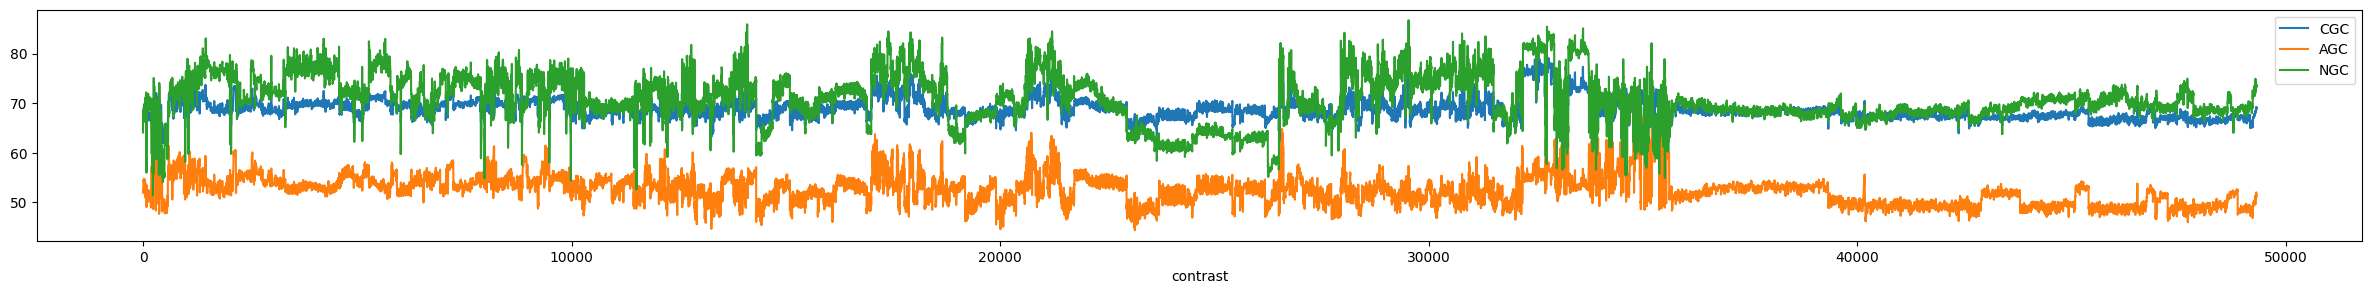

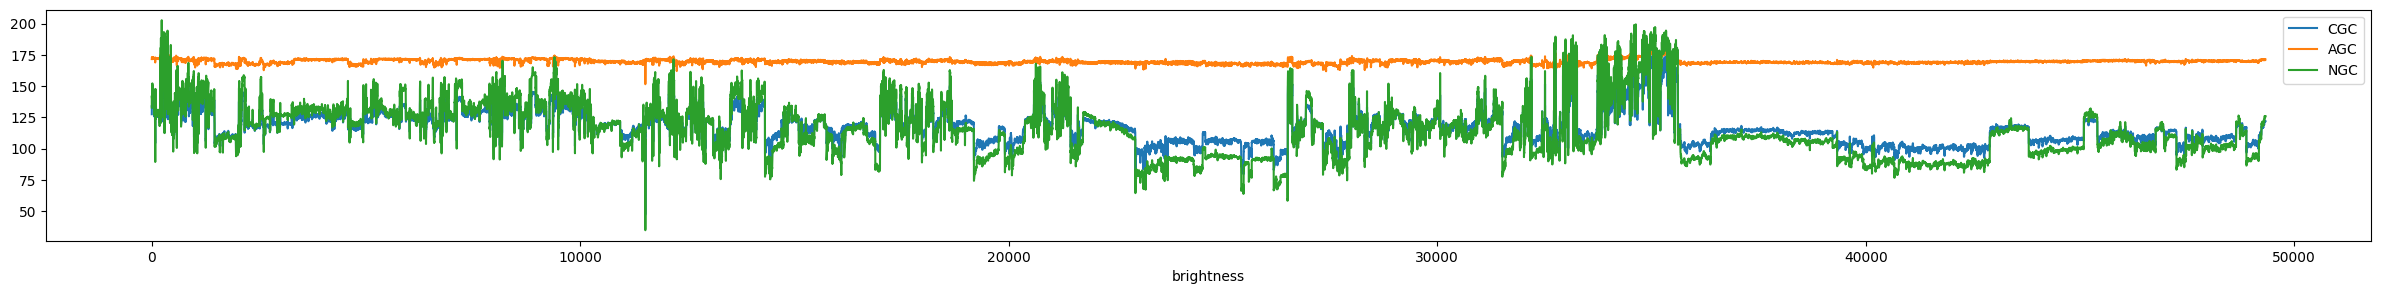

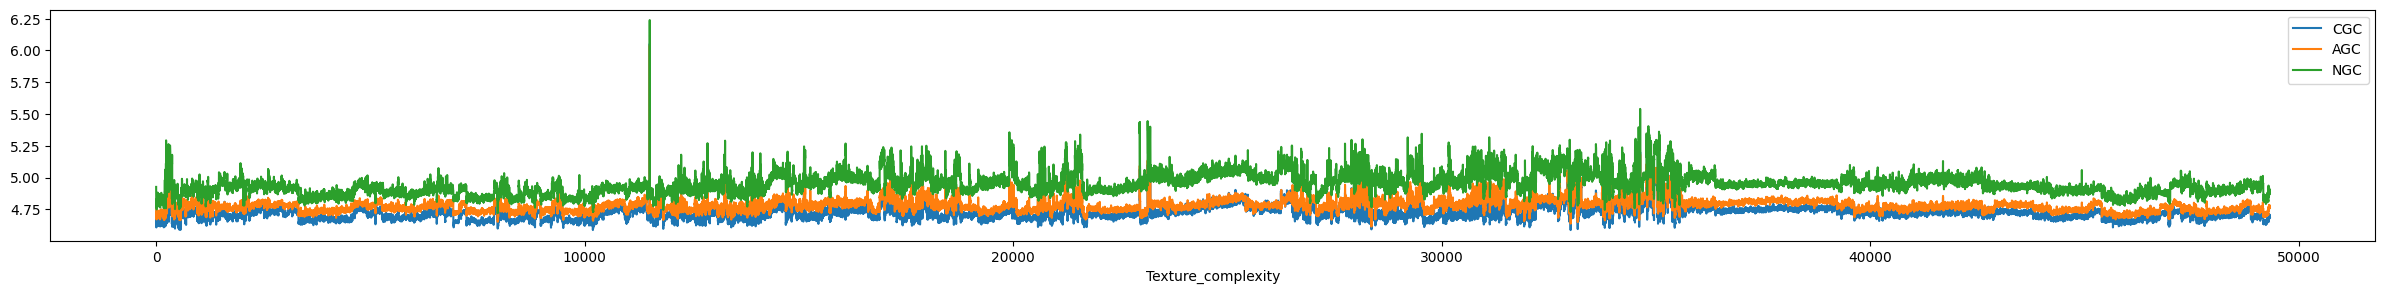

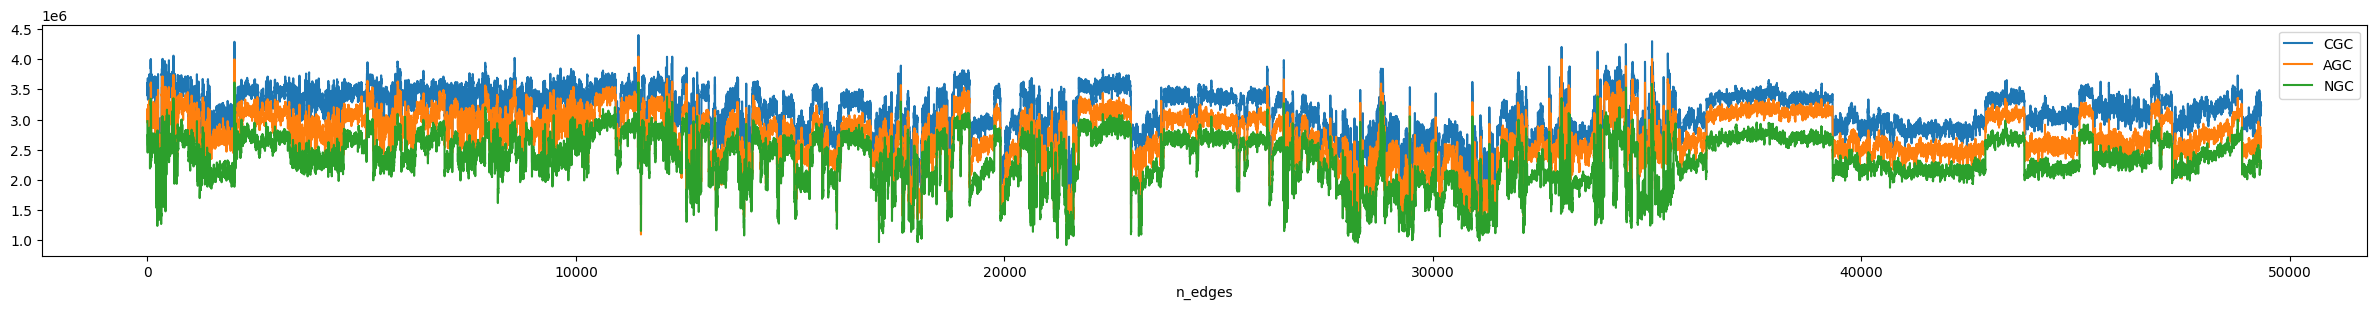

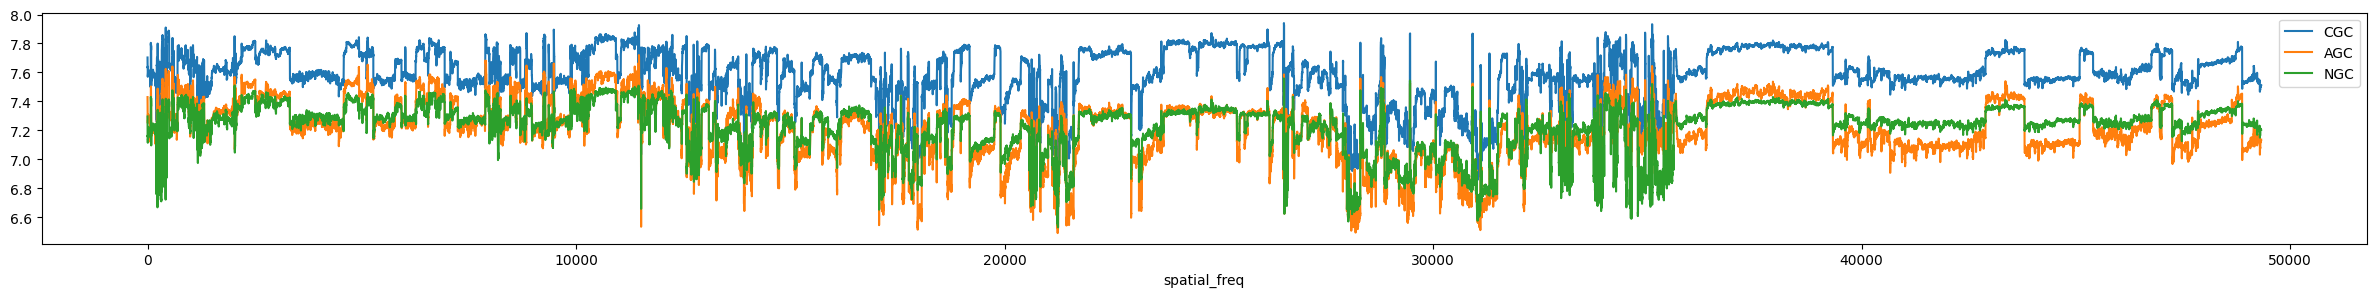

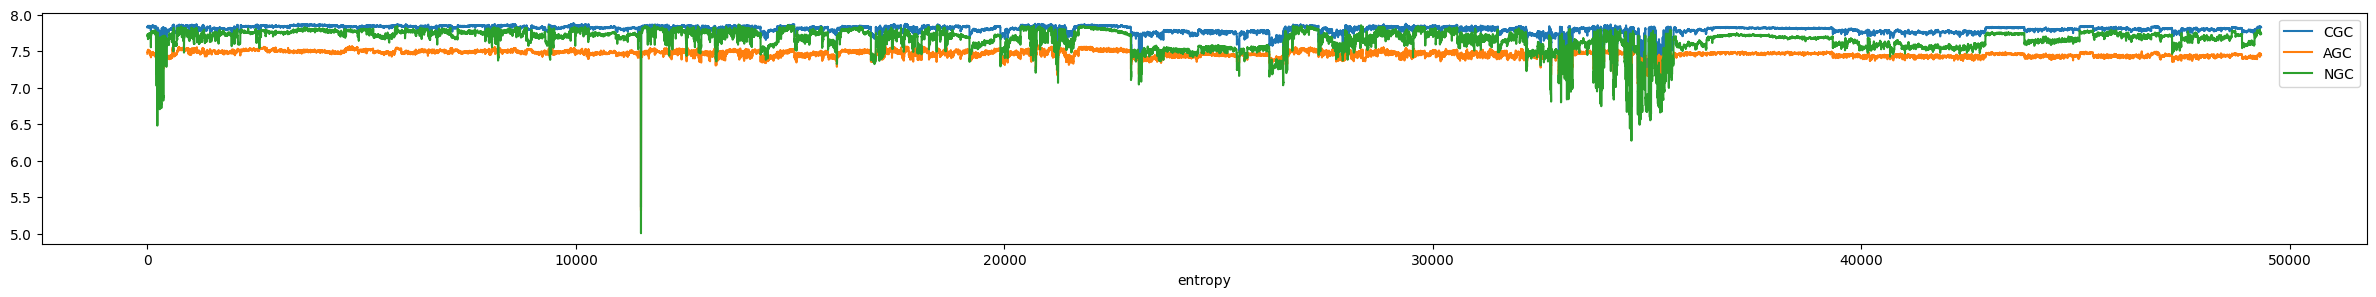

In [16]:
for i in stat.columns:
    plt.figure(figsize=[30, 3])
    plt.plot(stat[i], label = 'CGC')
    plt.plot(stat_agc[i], label = 'AGC')
    plt.plot(stat_ngc[i], label = 'NGC')
    plt.xlabel(i)
    # plt.xticks(clp_set)
    plt.legend()
    plt.show()
    

In [114]:

folder = []#'/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/frame_compare_stats.mp4', '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/frame_compare_stats_ngc.mp4'
# for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'Vids_2_compare')):
#     folder.append(os.path.join(os.path.join(os.path.dirname(to_dir), 'Vids_2_compare', file)))

for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'CP_Comp')):
    folder.append(os.path.join(os.path.join(os.path.dirname(to_dir), 'CP_Comp', file)))


folder = sorted(folder)

img_feats3 = adap_gamma_correct(folder[0])

for i in range(1, len(folder)):
    path=folder[i]
    t0 = time.time()
    img_feat = adap_gamma_correct(path)
    # print('img_feat', img_feat.shape)
    img_feats3 = np.concatenate((img_feats3, img_feat), axis=0)
    # print(img_feats)
    t1 = time.time()
    # print(img_feats)
    print((t1-t0))
        # print(path)

# folder

Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img00787.mp4

Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img00851.mp4

1.8365001678466797
Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img02041.mp4

1.7997283935546875
Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img02921.mp4

1.8546395301818848
Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img03093.mp4

1.8769207000732422
Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img03572.mp4

1.83231782913208
Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img05453.mp4

1.816065788269043
Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img05611.mp4

1.8392181396484375
Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img17803.mp4

1.7860360145568848
Done 

In [116]:
imgx = 7
stat = pd.DataFrame(img_feats3[imgx], columns=['contrast', 'brightness', 'Texture_complexity', 'n_edges', 'spatial_freq', 'entropy'])
# stat_ngc = pd.DataFrame(img_feats2[2], columns=['contrast', 'brightness', 'Texture_complexity', 'n_edges', 'spatial_freq', 'entropy'])
# (t1-t0)/250
# pd.concat([img_feats, img_feat], axis = 0)

pd.options.display.max_rows = 460
stat

,contrast,brightness,Texture_complexity,n_edges,spatial_freq,entropy
0,77.341208,129.132799,4.938997,9290.0,7.262261,7.750392
1,56.056389,167.146719,4.796133,9717.0,7.141266,7.578688
2,54.053575,167.748099,4.718099,11282.0,7.239955,7.553414
3,52.340363,168.276654,4.675391,12049.0,7.397541,7.522142
4,52.704863,168.286875,4.651276,13964.0,7.494922,7.539949
5,51.993585,168.451862,4.629987,14861.0,7.584028,7.523990
6,60.405988,167.266159,4.921198,7731.0,7.027907,7.474294
7,60.209677,167.483411,4.913711,7713.0,7.020412,7.477604
8,60.209164,167.451484,4.904401,7447.0,7.019235,7.482868
9,60.207092,167.464727,4.905365,7521.0,7.020317,7.487924


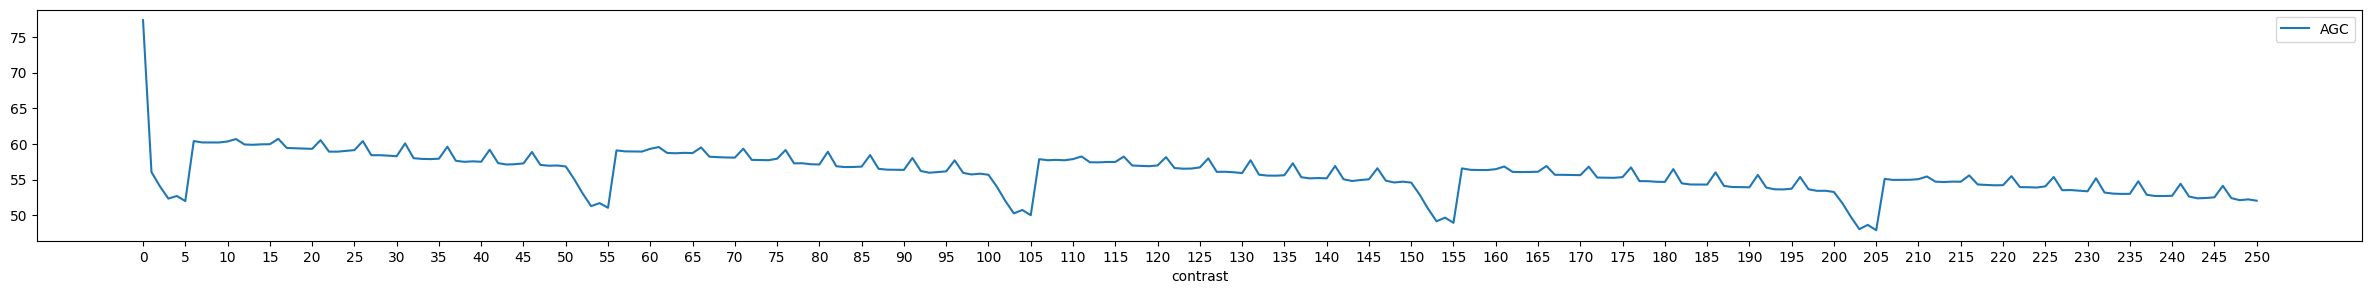

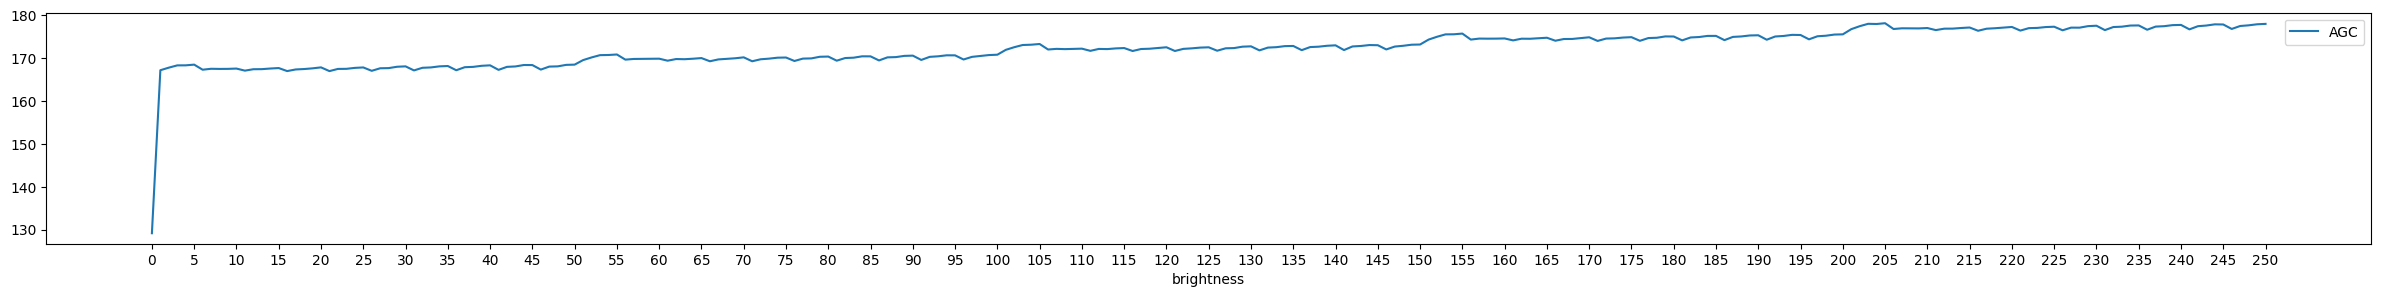

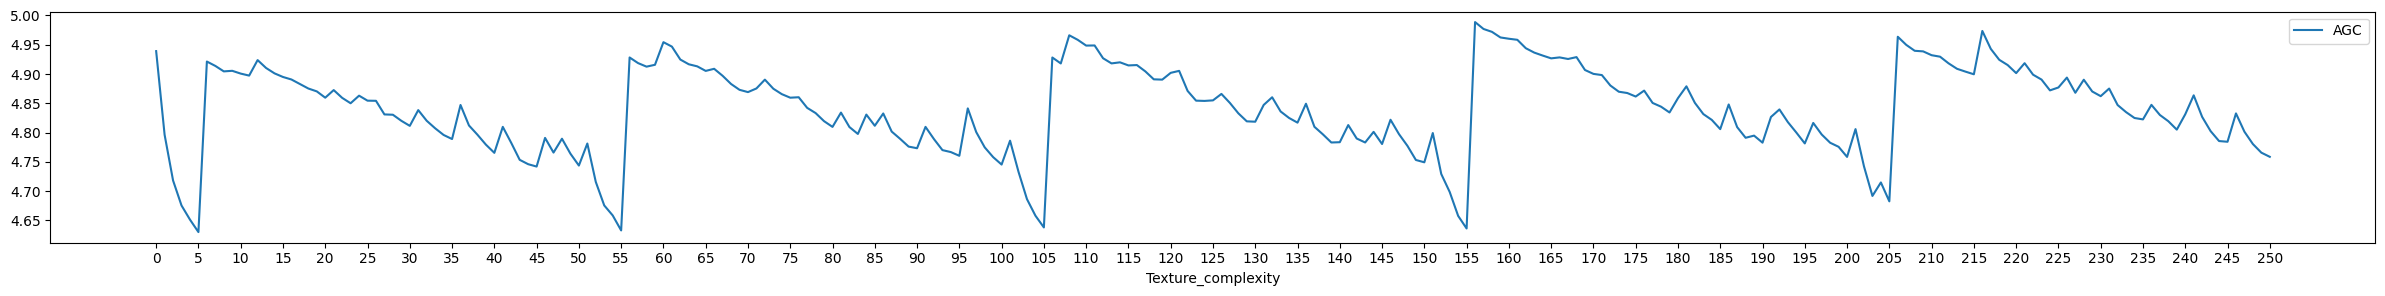

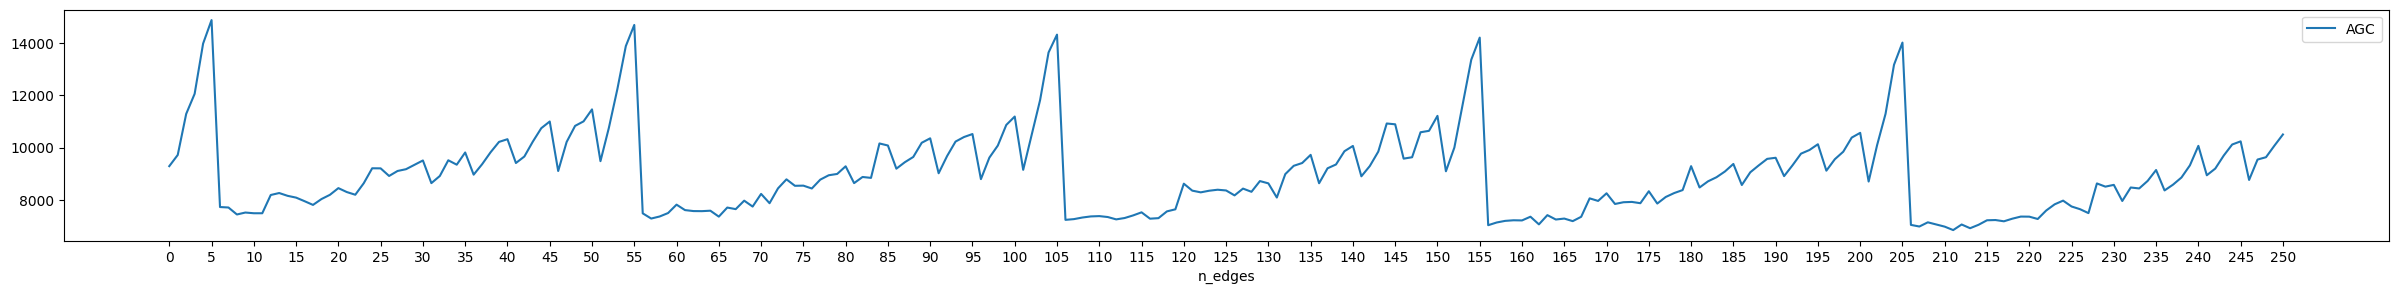

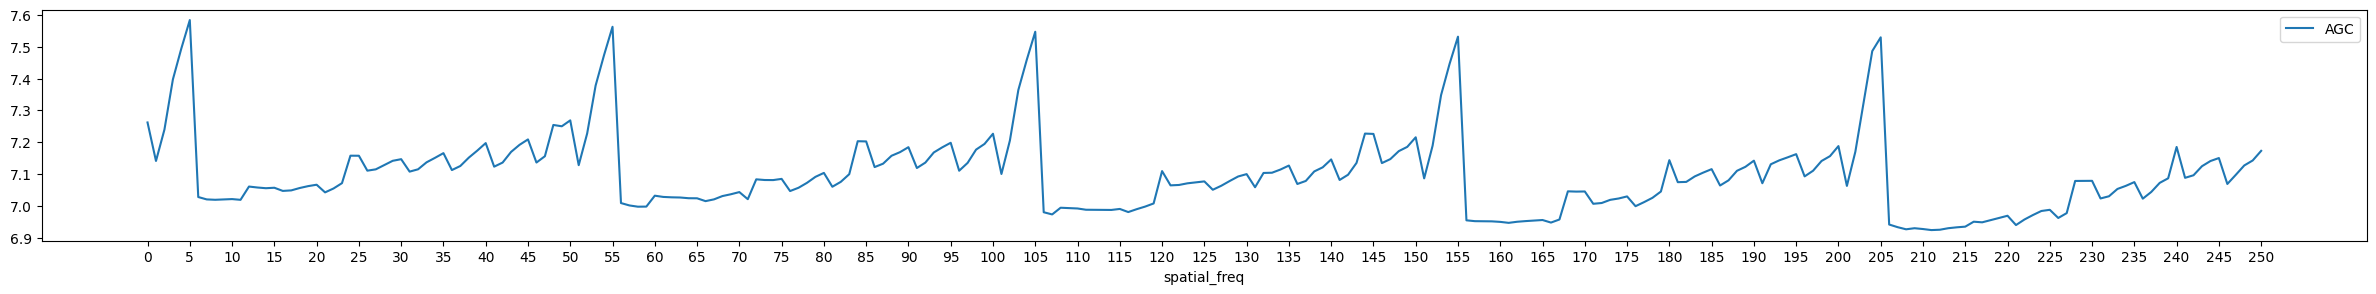

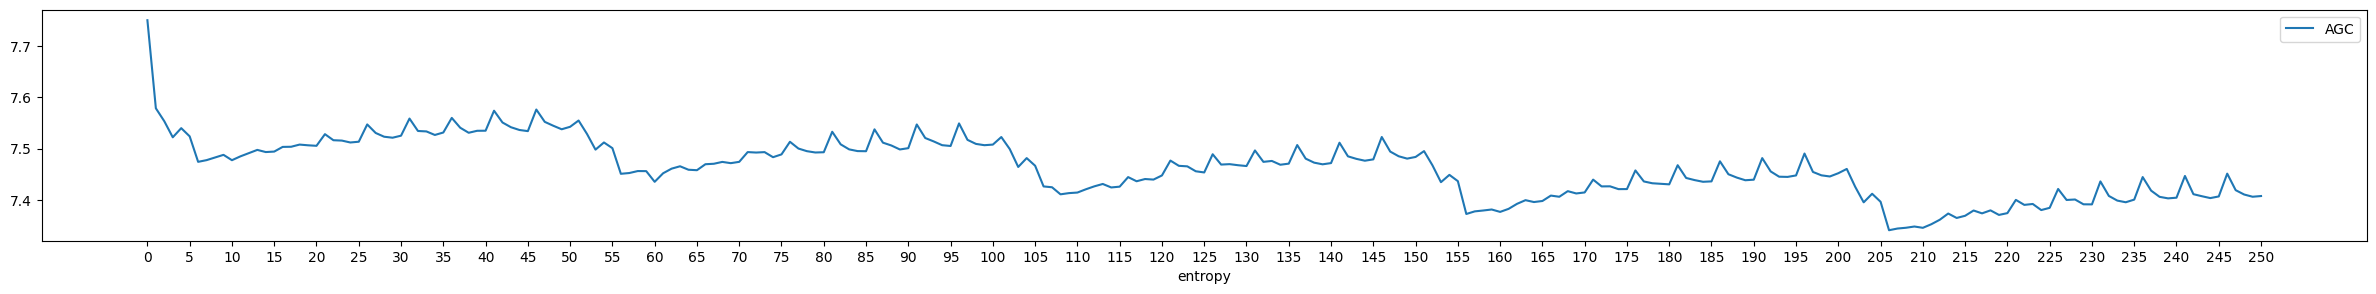

In [117]:
for i in stat.columns:
    plt.figure(figsize=[30, 3])
    plt.plot(stat[i], label = 'AGC')
    # plt.plot(stat_ngc[i], label = 'NGC')
    plt.xlabel(i)
    plt.xticks(np.arange(0, 251, step=5))
    plt.legend()
    plt.show()
    

In [121]:
clp_set
clp_setdf = pd.DataFrame(clp_set, columns=['targetbr', 'clp', 'grid', 'grid2'])
slc = clp_setdf.loc[clp_setdf.clp==1.8]
ind = slc.index.tolist()
# [clp_set[i] for i in ind]
# ind
slc

,targetbr,clp,grid,grid2
45,0.70,1.8,2,2
46,0.70,1.8,3,3
47,0.70,1.8,4,4
48,0.70,1.8,5,5
49,0.70,1.8,6,6
95,0.71,1.8,2,2
96,0.71,1.8,3,3
97,0.71,1.8,4,4
98,0.71,1.8,5,5
99,0.71,1.8,6,6


In [122]:
toplot = pd.DataFrame(stat.iloc[ind]).reset_index().drop('index', axis = 1)
# toplot = stat.iloc[ind]
toplot

,contrast,brightness,Texture_complexity,n_edges,spatial_freq,entropy
0,57.276042,168.349219,4.741875,10993.0,7.208993,7.534169
1,58.868432,167.293568,4.790807,9105.0,7.136282,7.576271
2,57.059122,167.993437,4.765755,10213.0,7.156123,7.552229
3,56.947759,168.047552,4.789414,10826.0,7.254438,7.544705
4,56.983686,168.394688,4.763867,10998.0,7.250244,7.537779
5,56.158109,170.615990,4.760234,10515.0,7.198418,7.505190
6,57.702967,169.648659,4.841185,8795.0,7.110577,7.549221
7,55.945819,170.263932,4.800703,9615.0,7.135205,7.517149
8,55.724130,170.484831,4.774701,10076.0,7.176902,7.509256
9,55.835146,170.681615,4.757969,10862.0,7.194774,7.506737


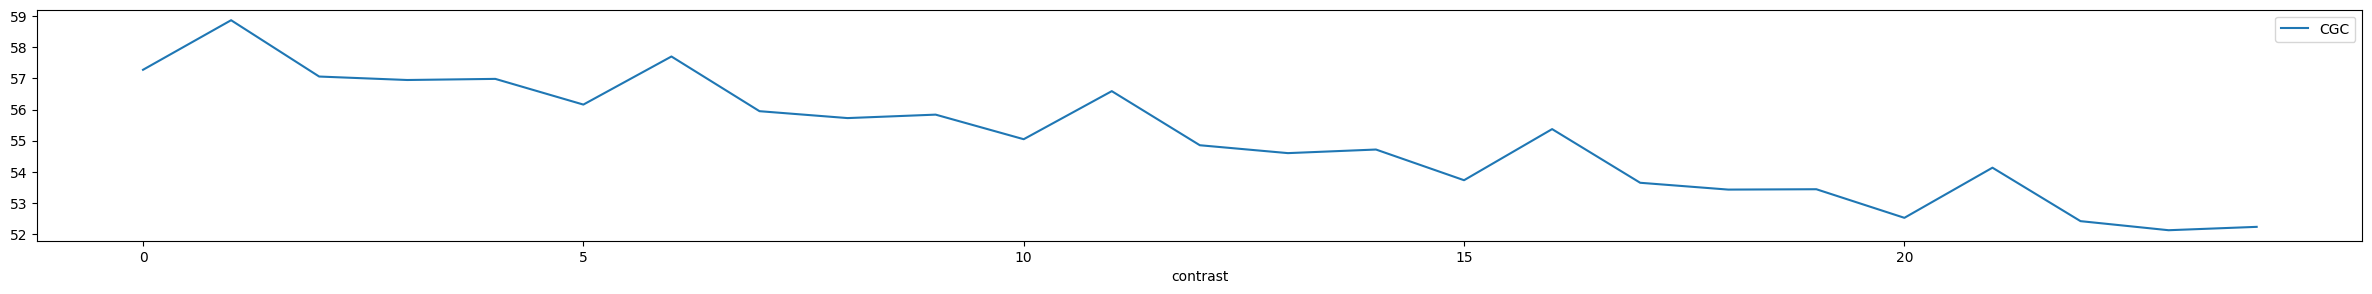

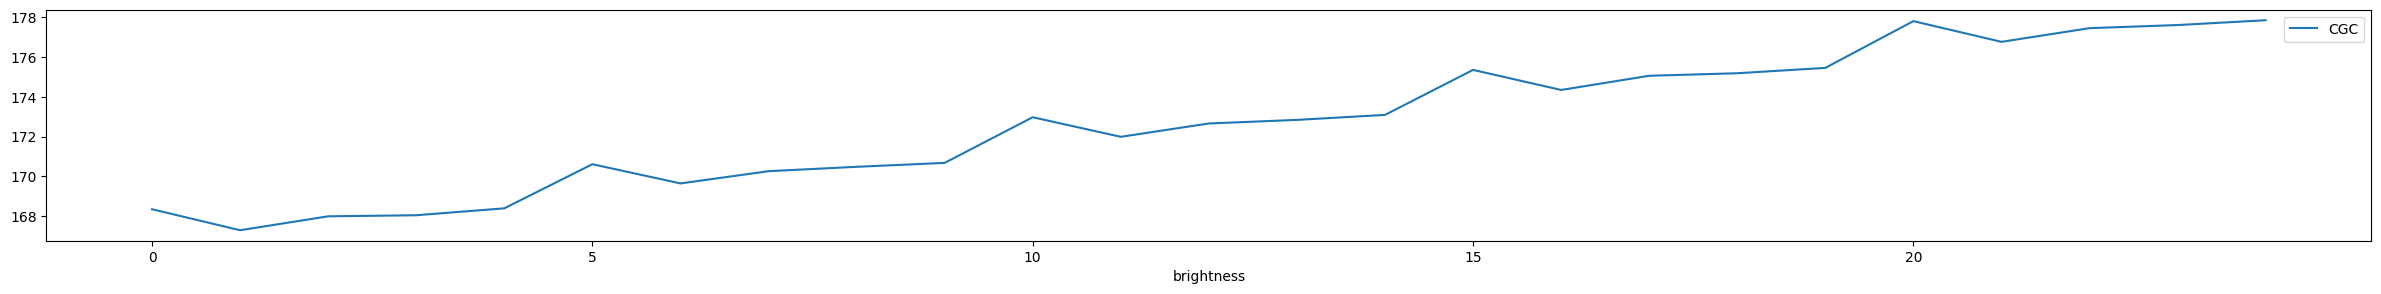

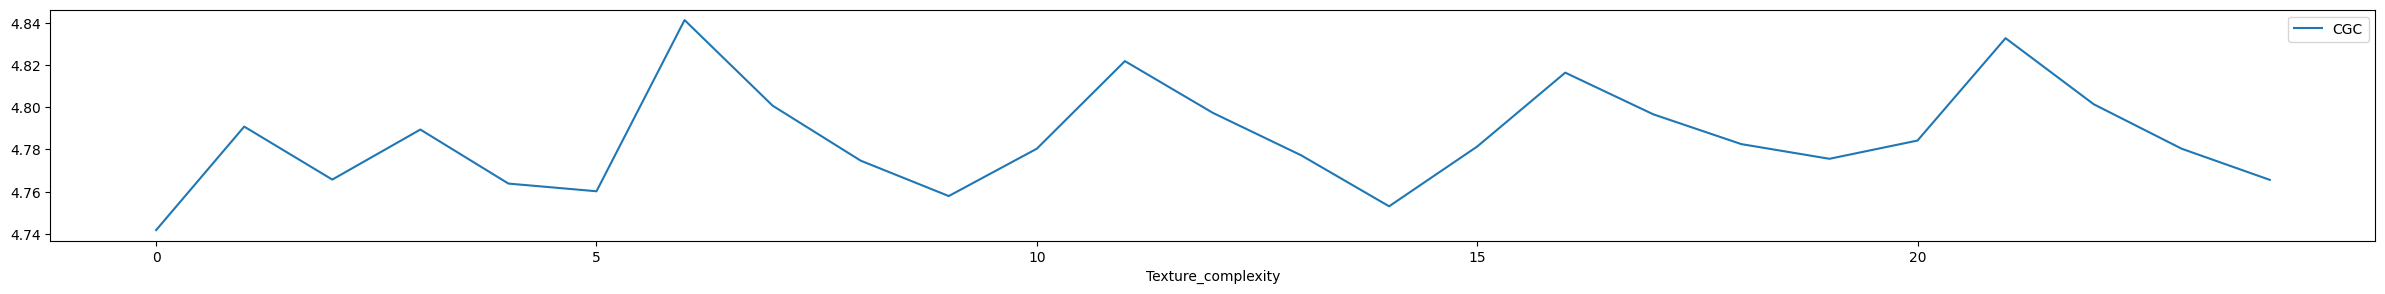

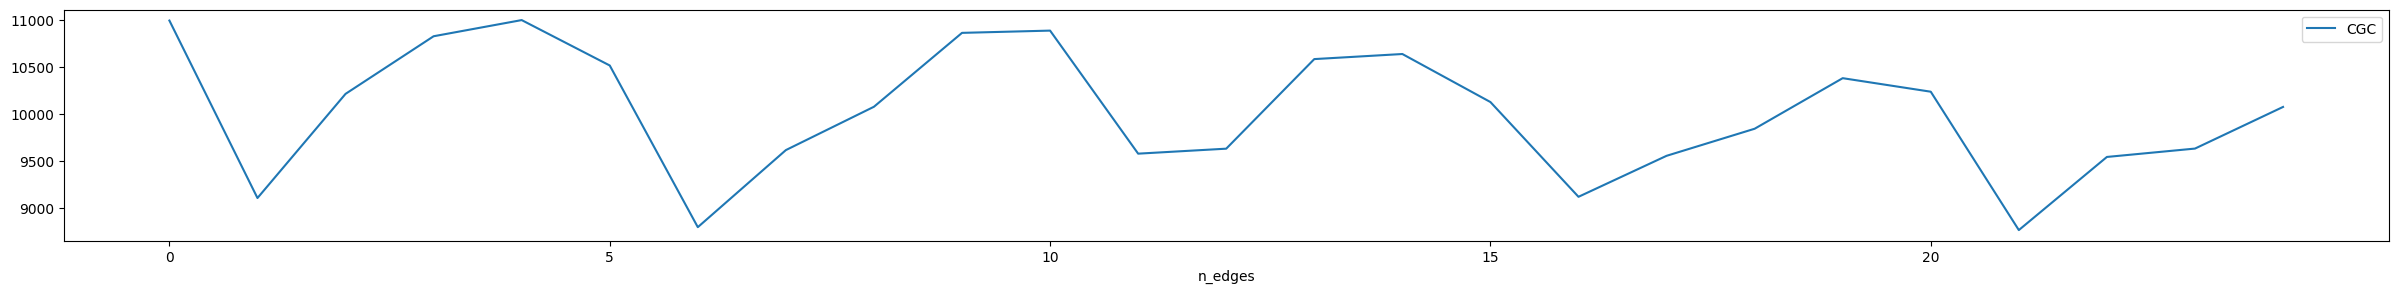

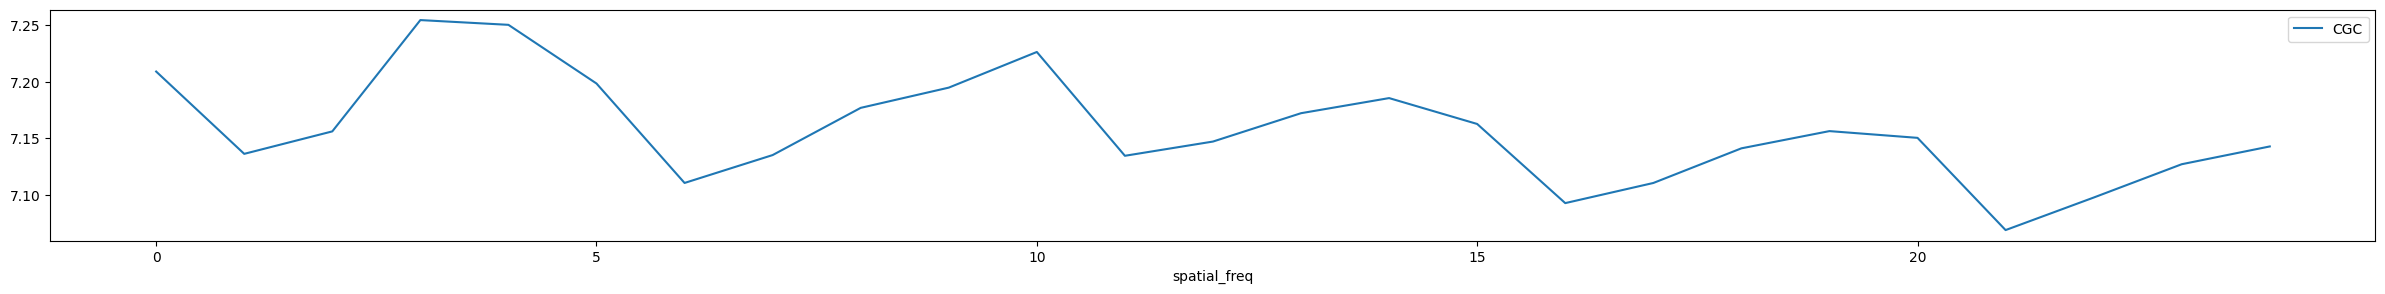

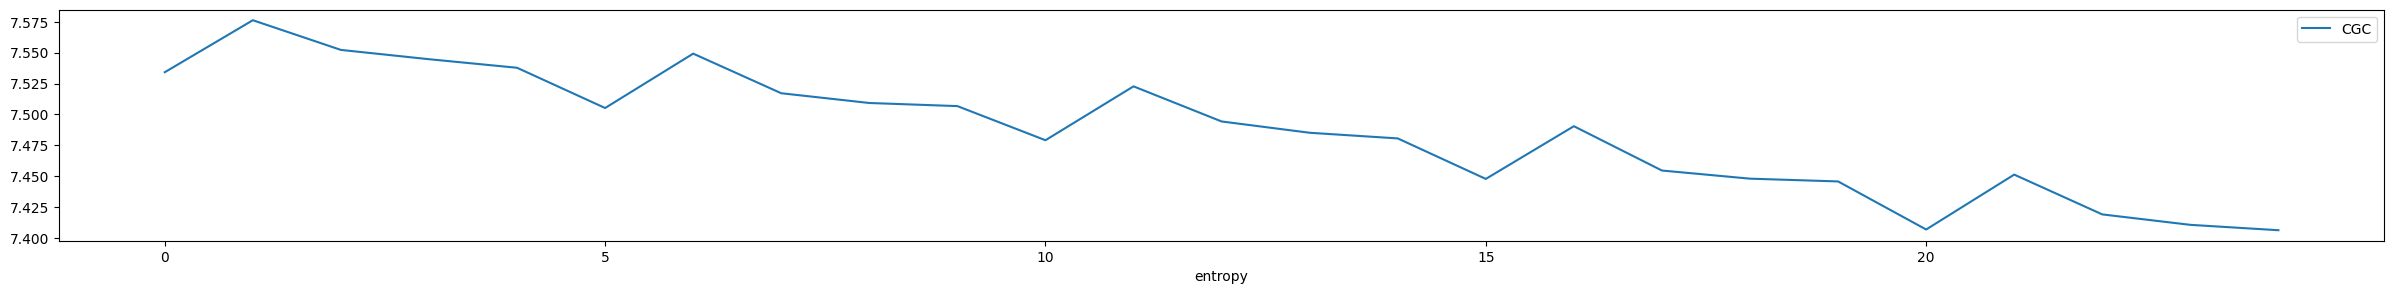

In [123]:
for i in toplot.columns:
    plt.figure(figsize=[30, 3])
    plt.plot(toplot[i], label = 'CGC')
    # plt.plot(stat_agc[i], label = 'AGC')
    # plt.plot(stat_ngc[i], label = 'NGC')
    plt.xlabel(i)
    plt.xticks(np.arange(0, toplot.shape[0], step=5))
    plt.legend()
    plt.show()

In [31]:

folder = []#'/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/frame_compare_stats.mp4', '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/frame_compare_stats_ngc.mp4'
for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'GC_Conv_vids')):
    if file.endswith('mgc.mp4'):
        continue
    folder.append(os.path.join(os.path.join(os.path.dirname(to_dir), 'GC_Conv_vids', file)))

# for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'CP_Comp')):
    # folder.append(os.path.join(os.path.join(os.path.dirname(to_dir), 'CP_Comp', file)))


folder = sorted(folder)

img_feats1 = adap_gamma_correct(folder[0])

for i in range(1, len(folder)):
    path=folder[i]
    t0 = time.time()
    img_feat = adap_gamma_correct(path)
    # print('img_feat', img_feat.shape)
    img_feats1 = np.concatenate((img_feats1, img_feat), axis=0)
    # print(img_feats)
    t1 = time.time()
    # print(img_feats)
    print((t1-t0))
        # print(path)

# folder

Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/GC_Conv_vids/Ken_Test_Long.mp4

Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/GC_Conv_vids/Ken_Test_Long_72_2_20_15_onlyClahe.mp4

1170.683512687683
Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/GC_Conv_vids/Ken_Test_Long_74.0_2_5_AGC_clahe.mp4

1170.4997372627258
Done -  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/GC_Conv_vids/Ken_Test_Long_GC.mp4



ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 13274 and the array at index 1 has size 13253

In [35]:
img_feats1.shape

(3, 13274, 6)

In [36]:
# img_feats2[4]
stat = pd.DataFrame(img_feats1[1], columns=['contrast', 'brightness', 'Texture_complexity', 'n_edges', 'spatial_freq', 'entropy'])
stat_agc = pd.DataFrame(img_feats1[0], columns=['contrast', 'brightness', 'Texture_complexity', 'n_edges', 'spatial_freq', 'entropy'])
stat_ngc = pd.DataFrame(img_feats1[2], columns=['contrast', 'brightness', 'Texture_complexity', 'n_edges', 'spatial_freq', 'entropy'])
# stat_ngc = pd.DataFrame(img_feats1[2], columns=['contrast', 'brightness', 'Texture_complexity', 'n_edges', 'spatial_freq', 'entropy'])
# (t1-t0)/250
# pd.concat([img_feats, img_feat], axis = 0)
stat

,contrast,brightness,Texture_complexity,n_edges,spatial_freq,entropy
0,59.770429,103.263513,5.513223,23900385.0,8.189515,7.565852
1,60.349240,105.729929,5.230168,21573000.0,8.155926,7.622903
2,60.294246,105.854939,5.154595,21594165.0,8.156526,7.626873
3,60.304620,105.845137,5.114806,21672960.0,8.158108,7.626354
4,61.473667,102.548160,5.128163,19750260.0,8.134154,7.612673
...,...,...,...,...,...,...
13269,55.070478,127.521721,4.911999,36418080.0,8.553949,7.627090
13270,54.987418,127.547194,4.922368,36219690.0,8.553799,7.625698
13271,55.002158,127.474090,4.932682,36229635.0,8.552788,7.625260
13272,54.948905,127.451910,5.049697,36136305.0,8.534340,7.620956


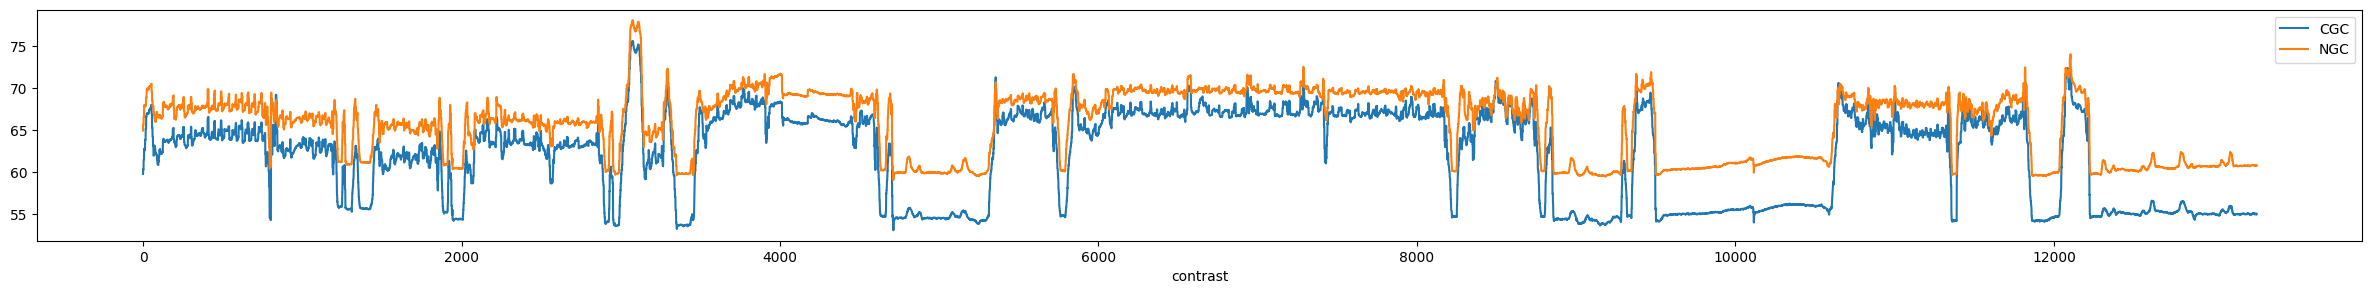

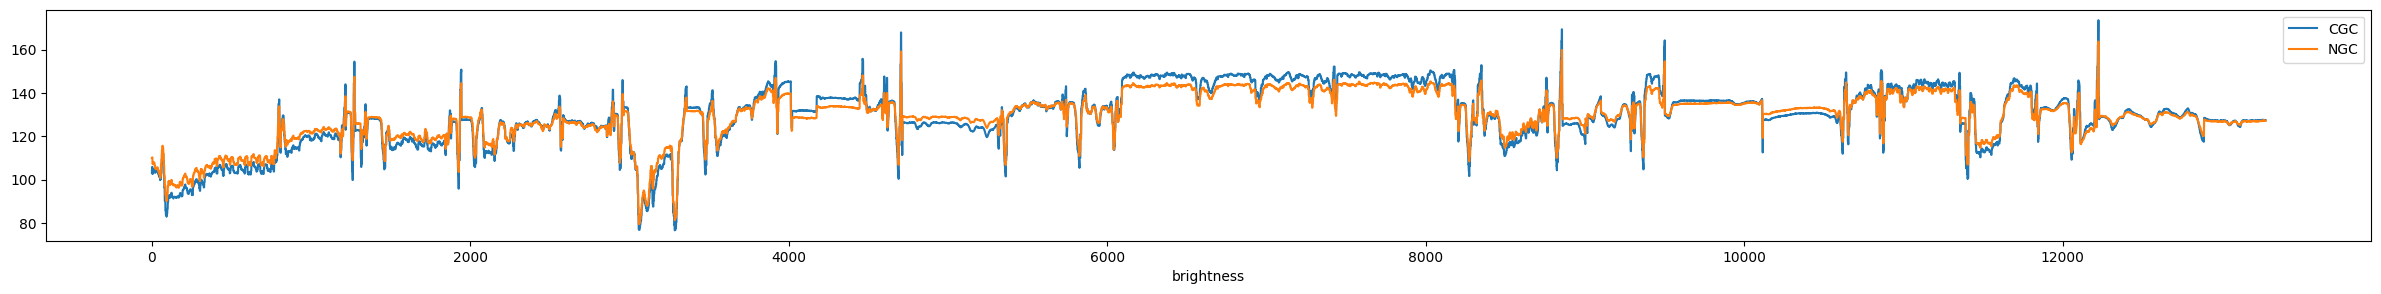

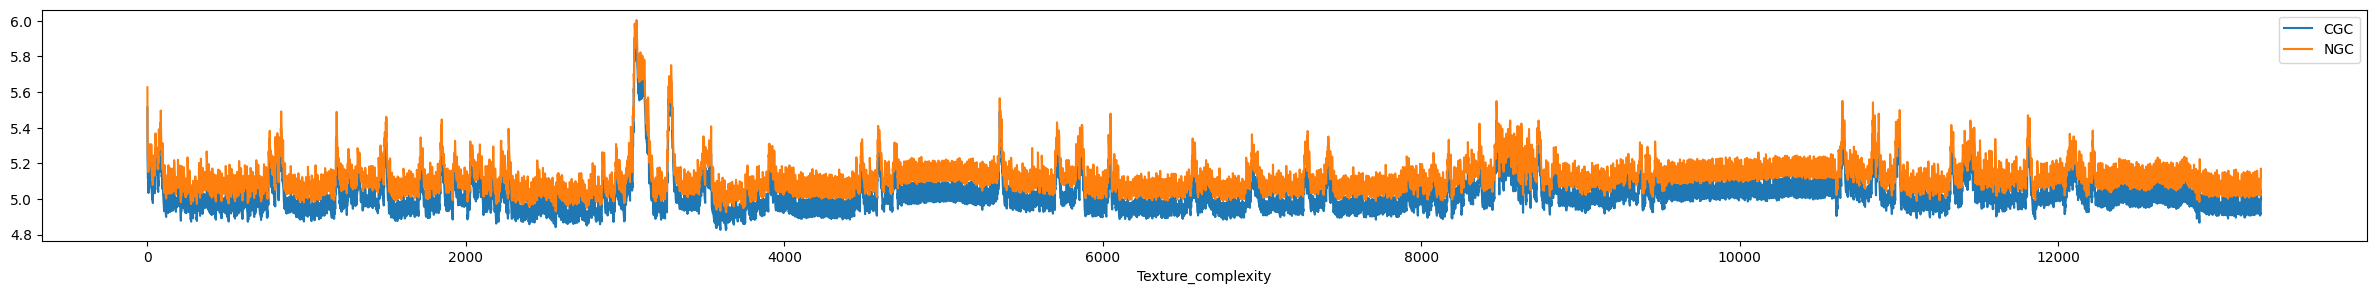

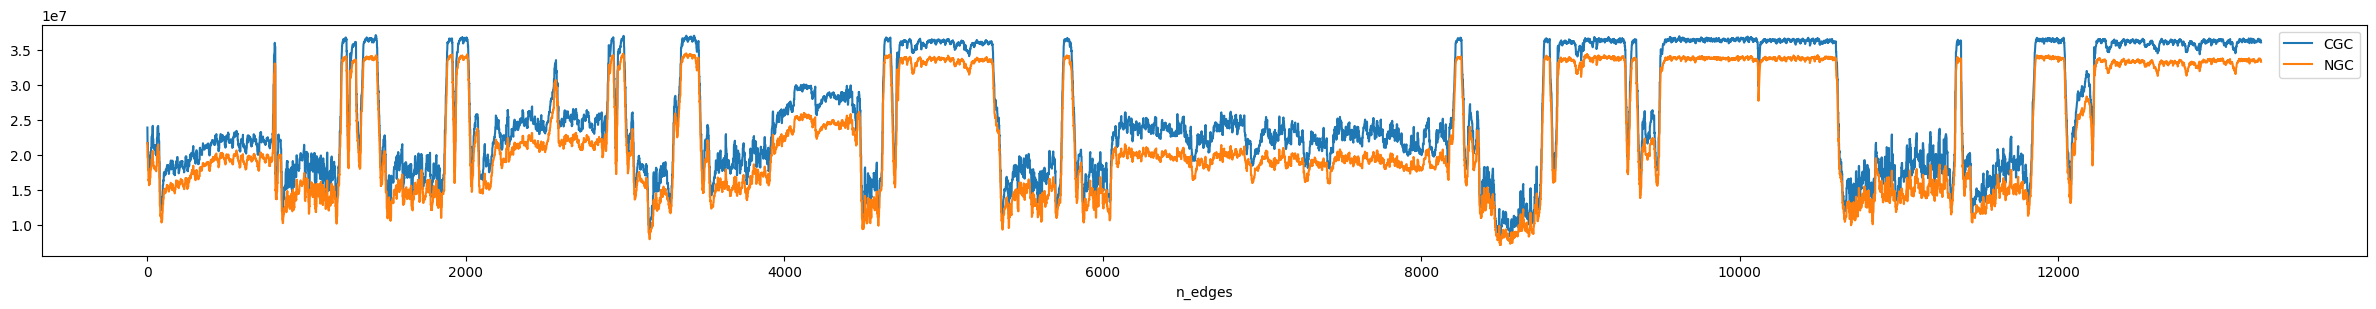

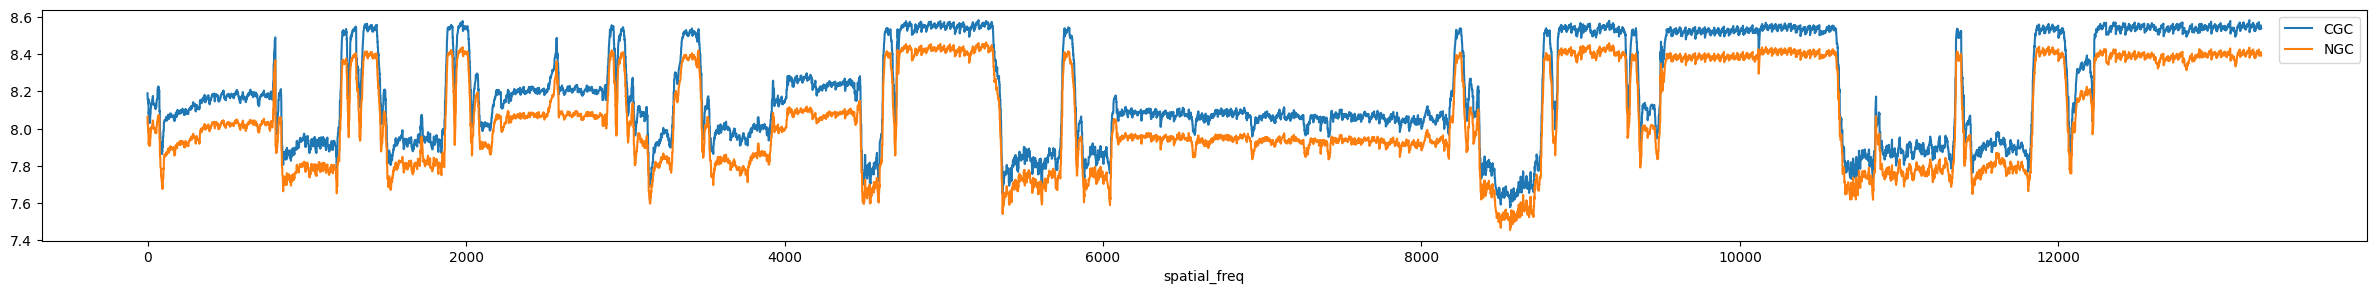

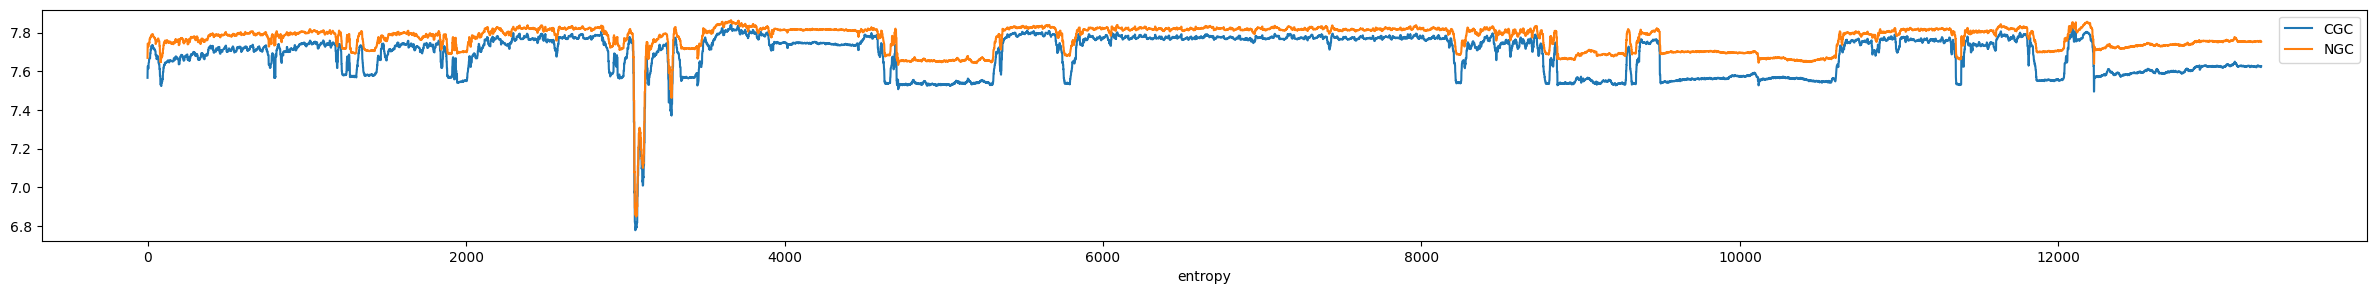

In [38]:
for i in stat.columns:
    plt.figure(figsize=[30, 3])
    plt.plot(stat[i], label = 'CGC')
    # plt.plot(stat_agc[i], label = 'AGC')
    plt.plot(stat_ngc[i], label = 'NGC')
    plt.xlabel(i)
    # plt.xticks(clp_set)
    plt.legend()
    plt.show()
    

In [47]:
clp_set[146]

[0.72, 1.8, [3, 3]]

In [21]:
for i in stat.columns:
    print(i)
    print(f'Mean {i} ngc = ', np.mean(stat[i]))
    print(f'std dev {i} ngc = ', np.std(stat[i]))
    print(f'Mean {i} agc = ', np.mean(stat_ngc[i]))
    print(f'std dev {i} agc = ', np.std(stat_ngc[i]))
    print(f'Mean {i} diff = ', np.mean(stat_ngc[i]-stat[i]))
    print(f'std dev {i} diff = ', np.std(stat_ngc[i]-stat[i]))
    print(stats.ttest_1samp(stat_ngc[i]-stat[i], popmean=0))
    print(f'Mean {i} diff = ', np.mean(stat[i]/stat_ngc[i]))
    print(f'std dev {i} diff = ', np.std(stat[i]/stat_ngc[i]))
    print(stats.ttest_1samp(stat[i]/stat_ngc[i], popmean=0))
    print()
    print()

contrast
Mean contrast ngc =  68.75660910440186
std dev contrast ngc =  2.0071921011224285
Mean contrast agc =  70.87830170621777
std dev contrast agc =  4.7576524681344114
Mean contrast diff =  2.121692601815921
std dev contrast diff =  3.752385125277916
TtestResult(statistic=125.57783910267355, pvalue=0.0, df=49326)
Mean contrast diff =  0.9733007493524426
std dev contrast diff =  0.053838589943022964
TtestResult(statistic=4015.0534396941916, pvalue=0.0, df=49326)


brightness
Mean brightness ngc =  117.81073700709464
std dev brightness ngc =  13.694665056960849
Mean brightness agc =  115.43749829633958
std dev brightness agc =  21.656996527275922
Mean brightness diff =  -2.373238710755097
std dev brightness diff =  8.443289592236207
TtestResult(statistic=-62.42631331956309, pvalue=0.0, df=49326)
Mean brightness diff =  1.0342980852492398
std dev brightness diff =  0.07847207429194336
TtestResult(statistic=2927.3087932272138, pvalue=0.0, df=49326)


Texture_complexity
Mean Texture_co

In [108]:
# vid_names = []
for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'GC_Conv_vids')):
    if file.endswith(".mp4"):
        path=os.path.join(os.path.join(os.path.dirname(to_dir), 'GC_Conv_vids', file))
        print(path)
        tbr = 0.72
        clp = 2
        # gs = 5
        video = cv2.VideoCapture(path)
        width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

        ar_gcd = math.gcd(width, height)
        
        # clp = (-contrast/75 + 2.92)
        
        
        
        # grid_number_w = width / 5
        # grid_number_h = height / 5
        
        gs_w = int(width / 64.0)
        gs_h = int(height / 48.0)
        
        # print(grid_number_w, grid_number_h)
        print(int(gs_w), int(gs_h))
        
        gs = [gs_w, gs_h]
        # gs = [5,5]
        # for clp in range(0, 10, 2):
        # adap_gamma_correct(path, tbr, clp, gs)
        set = [path, tbr, clp, gs]
        print(set)

/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/GC_Conv_vids/Ken_Test_Long_74.0_2_5_AGC_clahe.mp4
20 15
['/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/GC_Conv_vids/Ken_Test_Long_74.0_2_5_AGC_clahe.mp4', 0.72, 2, [20, 15]]
/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/GC_Conv_vids/Ken_Test_Long_72_2_20_15_onlyClahe.mp4
20 15
['/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/GC_Conv_vids/Ken_Test_Long_72_2_20_15_onlyClahe.mp4', 0.72, 2, [20, 15]]
/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/GC_Conv_vids/img05453.mp4
5 5
['/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/GC_Conv_vids/img05453.mp4', 0.72, 2, [5, 5]]
/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/GC_Conv_vids/Ken_Test_Long_GC.mp4
20 15
['/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/GC_Conv_vids/Ken_Test_Long_GC.mp4', 0.72, 2, [20, 15]]
/home/yashas/Documents/dlc_projects/Stats_Analysis_A

In [17]:
fl_name = '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/Frame_Ids2'
# open the file in the write mode
f = open(fl_name, 'w')
np.save(fl_name, img_feats2)
# write a row to the csv file
# af.to_csv(fl_name, index=False)

In [16]:
fl_name = '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/Frame_Ids2.npy'
x = np.load(fl_name)

In [17]:
x.shape

(14, 251, 6)

In [18]:
project_name = 'DLC_clp'
your_name = 'YR'
os.chdir('/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids')
csvfiles = []
# vid_to_crop = []
today = str(date.today())
# today = "2023-04-12"
proj_fold = project_name+'-'+your_name+'-'+today
# print(today)
target = os.path.join(os.getcwd(),proj_fold,'videos')
print(target)
for file in os.listdir(target):
    if file.endswith("_filtered.csv"):
        # print(file)
        csvfiles.append(os.path.join(target,file))
csvfiles = sorted(csvfiles)

/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/DLC_clp-YR-2024-01-12/videos


In [19]:
i = 0
x_ses_all = pd.read_csv(csvfiles[i], header = [1,2])[['RightEye_Inner', 'RightEye_Pupil', 'RightEye_Outer', 'LeftEye_Inner', 'LeftEye_Pupil', 'LeftEye_Outer', 'NostrilsTop_Centre']].drop('likelihood',level = 1, axis=1)


In [20]:
# x_ses_all = pd.DataFrame(x_ses_all)
x_ses_all

RightEye_Inner             RightEye_Pupil            RightEye_Outer  \
                 x           y              x          y              x   
0       200.781509   99.418175     194.506500  94.496490     187.767624   
1       201.498688  101.548843     196.218933  94.496490     192.436890   
2       201.553162  101.548843     196.218933  94.496490     192.616135   
3       201.901581  101.783958     196.218933  94.141525     192.616135   
4       202.049515  101.783958     196.213501  94.141525     192.598724   
..             ...         ...            ...        ...            ...   
246     202.653107  102.191750     196.056320  94.313957     191.942856   
247     202.867935  102.191750     196.944641  94.313957     192.302429   
248     202.893234  101.761963     196.944641  94.055931     192.494781   
249     202.893234  101.683952     196.575241  93.885460     192.302429   
250     202.893234  101.468056     196.575241  93.207710     192.302429   

               LeftEye_Inner             LeftEye_Pupil              \
             y             x           y             x           y   
0    96.637672    203.464615  100.991867    199.826614   96.233459   
1    96.637672    219.069412  105.812431    227.761200  109.524864   
2    96.637672    219.081238  105.828087    227.761200  109.868645   
3    96.637672    219.081238  106.151299    228.267349  110.432671   
4    96.446304    219.081238  106.151299    227.761200  110.432671   
..         ...           ...         ...           ...         ...   
246  95.842751    217.550781  105.585182    227.529388  109.300621   
247  95.842751    217.885788  105.585182    227.674072  109.564499   
248  95.842751    217.885788  105.412140    227.744186  109.564499   
249  95.834358    217.836655  105.256157    227.674072  109.300621   
250  95.610649    217.836655  105.041512    227.674072  109.287674   

    LeftEye_Outer             NostrilsTop_Centre              
                x           y                  x           y  
0      213.855865   97.680244         193.505585  135.649170  
1      235.726242  113.954208         194.482132  136.004196  
2      235.841751  113.954208         195.890411  136.008408  
3      236.856094  114.378754         195.890411  136.008408  
4      236.107910  114.378754         195.890411  136.008408  
..            ...         ...                ...         ...  
246    235.722107  115.098312         196.108765  136.596909  
247    235.937469  115.098312         196.108765  136.596909  
248    236.075943  114.738922         196.108765  136.596909  
249    235.425781  114.599548         195.702850  135.809341  
250    235.186081  114.481201         195.644043  135.065399  

[251 rows x 14 columns]

In [21]:
nam_lab_compare = man_lab.drop(['Unnamed: 1_level_0', 'bodyparts'], level = 0, axis = 1).set_index('Frame_no')
nam_lab_compare

RightEye_Inner             RightEye_Outer             \
                          x           y              x          y   
Frame_no                                                            
img00787.png     207.751013   98.844832     192.331037  90.184298   
img00851.png     172.505444   86.871251     146.930750  85.203336   
img02041.png     204.169337   90.860641     186.461975  79.402936   
img02921.png     217.189456   92.162653     202.606923  78.882132   
img03093.png     204.169337   72.632474     191.930425  62.476782   
img03572.png     179.474718   69.849003     159.627695  60.226205   
img05453.png     183.567490   84.956137     162.021770  78.619161   
img05611.png     190.326931   91.926811     171.527235  82.632579   
img17803.png     208.239514   98.293375     197.966945  76.785183   
img21517.png     222.502939  105.198644     214.170062  83.324844   
img28495.png     201.149943   95.563756     186.827813  76.814784   
img29057.png     198.545920   92.438927     182.400972  76.814784   
img29395.png     205.316382   95.042951     192.296263  72.387944   
img31039.png     210.524429   95.824158     196.983505  73.950358   

             RightEye_Pupil            LeftEye_Inner              \
                          x          y             x           y   
Frame_no                                                           
img00787.png     201.414037  95.887576    221.481129  106.026739   
img00851.png     160.969033  85.203336    186.126748   86.871251   
img02041.png     194.274047  84.090179    220.835090   96.068689   
img02921.png     210.418994  86.173398    229.949173   97.631103   
img03093.png     197.659278  65.080805    218.231066   78.882132   
img03572.png     170.620549  62.265117    195.278971   70.685066   
img05453.png     172.160932  80.309021    198.776233   88.335858   
img05611.png     181.877629  86.223533    204.901977   97.207625   
img17803.png     203.103230  84.810628    219.796154  110.492050   
img21517.png     219.638512  92.178525    229.273401  118.479165   
img28495.png     191.254653  85.408063    214.951270  102.334218   
img29057.png     188.650629  82.804039    211.566039   99.469791   
img29395.png     198.545920  82.283234    217.034489  103.896632   
img31039.png     204.274772  83.064441    223.125414  104.293730   

             LeftEye_Outer             LeftEye_Pupil              \
                         x           y             x           y   
Frame_no                                                           
img00787.png    240.069593  118.700691    229.296733  112.997413   
img00851.png    201.832946   83.813407    192.520422   84.508371   
img02041.png    238.542451   98.672712    228.907563   96.849896   
img02921.png    254.426997  117.942489    241.406878  107.786796   
img03093.png    236.719635   88.256617    227.084747   81.225753   
img03572.png    217.531693   71.286491    204.901769   68.880791   
img05453.png    213.562511   81.787649    205.113210   83.899975   
img05611.png    222.856743   96.996393    212.717581   98.052555   
img17803.png    231.673812  116.270370    224.290403  112.739175   
img21517.png    238.647886  125.249627    233.179436  122.385201   
img28495.png    225.627767  107.542265    217.294891  105.719449   
img29057.png    226.148572  106.500656    217.034489  101.292608   
img29395.png    234.481448  108.583875    223.544548  104.417437   
img31039.png    241.052814  110.285172    232.587132  107.181852   

             NostrilsTop_Centre              
                              x           y  
Frame_no                                     
img00787.png         195.288293  142.781202  
img00851.png         185.014805  133.850851  
img02041.png         201.304911  149.190774  
img02921.png         200.523704  147.628360  
img03093.png         186.982780  119.244500  
img03572.png         175.431948  126.617583  
img05453.png         194.340350  145.791111  
img05611.png         193.284187  149.804529  
img17803.png       

In [71]:
feature_names = ['RightEye_Inner', 'RightEye_Pupil', 'RightEye_Outer', 'LeftEye_Inner', 'LeftEye_Pupil', 'LeftEye_Outer']
least_diff_frames = []

for i in csvfiles:
    frame2check = os.path.basename(i).split('DLC')[0]+'.png'
    frame_comp_vals = pd.read_csv(i, header = [1,2])[['RightEye_Inner', 'RightEye_Pupil', 'RightEye_Outer', 'LeftEye_Inner', 'LeftEye_Pupil', 'LeftEye_Outer', 'NostrilsTop_Centre']].drop('likelihood',level = 1, axis=1)
    compcord = nam_lab_compare.loc[frame2check]
    least_diff_frame = []
    for j in feature_names:
        mancord4pt = compcord[j]
        x = mancord4pt.x
        y = mancord4pt.y
        predcord4pt = frame_comp_vals[j]
        diff = []
        for k in range(predcord4pt.shape[0]):
            x1 = predcord4pt.loc[k].x
            y1 = predcord4pt.loc[k].y
            diff.append(((x1-x)**2 + (y1-y)**2)**(1/2))
        least_diff_frame.append(np.argmin(diff))
    least_diff_frames.append([i, sorted(least_diff_frame)])
least_diff_frames


[['/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/DLC_clp-YR-2024-01-12/videos/img00787DLC_resnet50_DLC_clpJan12shuffle1_1030000_filtered.csv',
  [123, 124, 163, 164, 203, 208]],
 ['/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/DLC_clp-YR-2024-01-12/videos/img00851DLC_resnet50_DLC_clpJan12shuffle1_1030000_filtered.csv',
  [0, 0, 1, 23, 61, 163]],
 ['/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/DLC_clp-YR-2024-01-12/videos/img02041DLC_resnet50_DLC_clpJan12shuffle1_1030000_filtered.csv',
  [0, 0, 103, 104, 203, 231]],
 ['/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/DLC_clp-YR-2024-01-12/videos/img02921DLC_resnet50_DLC_clpJan12shuffle1_1030000_filtered.csv',
  [10, 15, 75, 152, 227, 244]],
 ['/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/DLC_clp-YR-2024-01-12/videos/img03093DLC_resnet50_DLC_clpJan12shuffle1_1030000_filtered.csv',
  [114, 114, 152, 196, 229, 249]],
 ['/home/yashas/Documents/dlc_proje

In [75]:
feature_names = ['RightEye_Inner', 'RightEye_Pupil', 'RightEye_Outer', 'LeftEye_Inner', 'LeftEye_Pupil', 'LeftEye_Outer']
least_diff_frames2 = []
for i in csvfiles:
    frame2check = os.path.basename(i).split('DLC')[0]+'.png'
    frame_comp_vals = pd.read_csv(i, header = [1,2])[['RightEye_Inner', 'RightEye_Pupil', 'RightEye_Outer', 'LeftEye_Inner', 'LeftEye_Pupil', 'LeftEye_Outer', 'NostrilsTop_Centre']].drop('likelihood',level = 1, axis=1)
    compcord = nam_lab_compare.loc[frame2check]
    diff = []
    for j in range(frame_comp_vals.shape[0]):
        frame_mod_cord = frame_comp_vals.loc[j]
        diffsum = 0
        for k in feature_names:
            mancord4pt = compcord[k]
            x = mancord4pt.x
            y = mancord4pt.y
            x1 = frame_mod_cord[k].x
            y1 = frame_mod_cord[k].y
            diffsum += ((x1-x)**2 + (y1-y)**2)**(1/2) 
        diff.append(diffsum)
    least_diff_frames2.append([frame2check, np.argmin(diff)])
least_diff_frames2

[['img00787.png', 226],
 ['img00851.png', 0],
 ['img02041.png', 103],
 ['img02921.png', 175],
 ['img03093.png', 115],
 ['img03572.png', 129],
 ['img05453.png', 129],
 ['img05611.png', 183],
 ['img17803.png', 204],
 ['img21517.png', 206],
 ['img28495.png', 17],
 ['img29057.png', 207],
 ['img29395.png', 205],
 ['img31039.png', 45]]

In [54]:
# len(least_diff_frames)

In [64]:
fr2ext_fram = (set(least_diff_frames2))

In [67]:
fr2ext_feat = set(least_diff_frame)
len(fr2ext_feat)

55

In [96]:
output_name = '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/frame_compare_stats.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 1
out = cv2.VideoWriter(output_name, fourcc, fps, (320, 240))

output_name2 = '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/frame_compare_stats_ngc.mp4'
out2 = cv2.VideoWriter(output_name2, fourcc, fps, (320, 240))
for i in least_diff_frames2:
    path = os.path.join(os.path.join(os.path.dirname(to_dir), 'CP_Comp', i[0].split('.')[0]+'.mp4'))
    video = cv2.VideoCapture(path)

    video.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, frame = video.read()
    if not ret:
        print(i)
        continue
    out2.write(frame)
    
    video.set(cv2.CAP_PROP_POS_FRAMES, i[1])
    ret, frame = video.read()
    if not ret:
        print(i)
        continue
    out.write(frame)
video.release()

        

In [ ]:
for i in csvfiles:
    img = pd.read_csv(csvfiles[i], header = [1,2])[['RightEye_Inner', 'RightEye_Pupil', 'RightEye_Outer', 'LeftEye_Inner', 'LeftEye_Pupil', 'LeftEye_Outer', 'NostrilsTop_Centre']]
    

In [ ]:
if not os.path.exists('Compare'):
        os.makedirs('Compare')
        
for file in os.listdir(os.getcwd()):
    if file.endswith("AGC_clahe.mp4"):
        chpth = os.path.join(os.path.join(os.path.dirname(file), 'Compare', file))
        shutil.move(file, chpth)

In [ ]:
# # vid_names = []
# for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'Conv_vids')):
#     # if file.endswith("downsampled.mp4"):
#     path=os.path.join(os.path.join(os.path.dirname(to_dir), 'Conv_vids', file))
#     adap_gamma_correct(path)
#     # print(path)

In [ ]:
# # vid_names = []
# for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'GC_Conv_vids')):
#     if file.endswith("AGC_clahe.mp4"):
#         path=os.path.join(os.path.join(os.path.dirname(to_dir), 'GC_Conv_vids', file))
#         adap_gamma_correct_sharp(path)
#         # print(path)

In [ ]:
# os.path.join(os.path.dirname(os.path.dirname(input_file)), 'All_vids/Conv_vids', out_name +'_conv.mp4')
# out_name = os.path.splitext(os.path.basename(path))[0].lstrip('.') + '.mp4'
# out_name

In [113]:
os.chdir('/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/')
os.getcwd()

'/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids'

In [ ]:
# folder = [] 
# for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'GC_Conv_vids')):
#     if file.endswith(".mp4"):
#         path=os.path.join(os.path.join(os.path.dirname(to_dir), 'GC_Conv_vids', file))
#         folder.append(path)
        
# # folder2 = [] 
# # for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'Conv_vids')):
# #     if file.endswith(".mp4"):
# #         path=os.path.join(os.path.join(os.path.dirname(to_dir), 'Conv_vids', file))
# #         folder2.append(path)
        
folder

In [21]:
# folder = [] 
# for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'Vids_2_compare')):
#     if file.endswith("ngc.mp4"):
#         path=os.path.join(os.path.join(os.path.dirname(to_dir), 'Vids_2_compare', file))
#         folder.append(path)

folder = [] 
for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'CP_Comp')):
    if file.endswith(".mp4"):
        path=os.path.join(os.path.join(os.path.dirname(to_dir), 'CP_Comp', file))
        folder.append(path)
        
# folder2 = [] 
# for file in os.listdir(os.path.join(os.path.dirname(to_dir), 'Conv_vids')):
#     if file.endswith(".mp4"):
#         path=os.path.join(os.path.join(os.path.dirname(to_dir), 'Conv_vids', file))
#         folder2.append(path)
        
folder

['/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img17803.mp4',
 '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img00787.mp4',
 '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img29057.mp4',
 '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img31039.mp4',
 '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img05611.mp4',
 '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img05453.mp4',
 '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img02921.mp4',
 '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img03572.mp4',
 '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img03093.mp4',
 '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img21517.mp4',
 '/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img29395.mp4',
 '/home/yashas/Docume

In [23]:
project_name = 'DLC_clp'
your_name = 'YR'

In [10]:
def process(fold, project_name, your_name):
    file = fold[0]
    print(file)
    bodyparts = ['RightEye_Outer', 'RightEye_Top', 'RightEye_Bottom', 'RightEye_Inner', 'RightEye_Pupil', 'LeftEye_Outer', 'LeftEye_Top', 'LeftEye_Bottom', 'LeftEye_Inner', 'LeftEye_Pupil',
                 'OutlineTop_Mid','RightNostrils_Top', 'RightNostrils_Bottom','LeftNostrils_Top', 'LeftNostrils_Bottom']
    videotype = os.path.splitext(file)[-1].lstrip('.')  # or MOV, or avi, whatever you uploaded!
    video_down = folder
    name_fold = 'Analyse_' + os.path.basename(os.path.dirname(file))
    
    model_options = deeplabcut.create_project.modelzoo.Modeloptions
    model_selection = 'primate_face'

    config_path, train_config_path = deeplabcut.create_pretrained_project(
        project_name,
        your_name,
        video_down,
        videotype=videotype,
        model=model_selection,
        analyzevideo=True,
        createlabeledvideo=False,
        copy_videos=False,
    )

    edits = {
        'dotsize': 1.2,  # size of the dots!
        'pcutoff': 0.4,  # the higher, the more conservative the plotting!
    }
    deeplabcut.auxiliaryfunctions.edit_config(config_path, edits)
    project_path = os.path.dirname(config_path)
    full_video_path = []
    for i in fold:
        full_video_path.append(os.path.join(project_path,'videos', os.path.basename(i)))

    # filter predictions (should already be done above ;):
    deeplabcut.filterpredictions(config_path, full_video_path, videotype=videotype)

    # re-create the video with your edits!
    # deeplabcut.CropVideo(config_path, full_video_path, 'crop', 
    deeplabcut.create_labeled_video(config_path, full_video_path, videotype=videotype, displayedbodyparts=bodyparts, draw_skeleton = True, filtered=True)
    
    

In [24]:
process(folder, project_name, your_name)
notify('DLC Done')
# all_fold = [folder2, folder]
# print(all_fold)

/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img17803.mp4
Created "/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos"
Created "/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/labeled-data"
Created "/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/training-datasets"
Created "/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/dlc-models"
Attempting to create a symbolic link of the video ...
Created the symlink of /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img17803.mp4 to /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img17803.mp4
Created the symlink of /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/img00787.mp4 to /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_v

/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/dlc-models/iteration-0/DLC_clpJan12-trainset95shuffle1/train/pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/dlc-models/iteration-0/DLC_clpJan12-trainset95shuffle1


/home/yashas/anaconda3/envs/dlctrial/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2024-01-12 12:17:35.985929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-12 12:17:35.986017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-12 12:17:35.986056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-12 12:17:35.986124: I tensorflow/str

Analyzing all the videos in the directory...
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img00787.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img00787.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 610.47it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img02921.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img02921.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 628.53it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img00851.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img00851.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 632.58it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img28495.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img28495.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 662.94it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img21517.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img21517.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 644.09it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img05453.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img05453.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 660.83it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img03572.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img03572.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 623.91it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img17803.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img17803.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 601.83it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img02041.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img02041.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 630.92it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img29395.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img29395.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 668.09it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img05611.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img05611.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 664.48it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img31039.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img31039.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 627.83it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img03093.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img03093.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 651.34it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
Starting to analyze %  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img29057.mp4
Loading  /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img29057.mp4
Duration of video [s]:  50.2 , recorded with  5.0 fps!
Overall # of frames:  251  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 655.12it/s]


Saving results in /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img17803.mp4
Saving filtered csv poses!
Filtering with median model /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img00787.mp4
Saving filtered csv poses!
Filtering with median model /home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids/CP_Comp/DLC_clp-YR-2024-01-12/videos/img29057.mp4
Saving filtered csv poses!
Filtering with median model /home/yashas/Docu

  0%|                                                   | 0/251 [00:00<?, ?it/s]

Duration of video [s]: 50.2, recorded with 5.0 fps!

Duration of video [s]: 50.2, recorded with 5.0 fps!Generating frames and creating video.

  0%|                                                   | 0/251 [00:00<?, ?it/s]

Overall # of frames: 251 with cropped frame dimensions: 320 240




  0%|                                                   | 0/251 [00:00<?, ?it/s]

Overall # of frames: 251 with cropped frame dimensions: 320 240Generating frames and creating video.

Generating frames and creating video.

  0%|                                                   | 0/251 [00:00<?, ?it/s]


Duration of video [s]: 50.2, recorded with 5.0 fps!


  0%|                                                   | 0/251 [00:00<?, ?it/s]

Overall # of frames: 251 with cropped frame dimensions: 320 240

  0%|                                                   | 0/251 [00:00<?, ?it/s]


Generating frames and creating video.Duration of video [s]: 50.2, recorded with 5.0 fps!Duration of video [s]: 50.2, recorded with 5.0 fps!Duration of video [s]: 50.2, recorded with 5.0 fps!




  0%|                                                   | 0/251 [00:00<?, ?it/s]


Overall # of frames: 251 with cropped frame dimensions: 320 240Duration of video [s]: 50.2, recorded with 5.0 fps!Overall # of frames: 251 with cropped frame dimensions: 320 240Overall # of frames: 251 with cropped frame dimensions: 320 240



Generating frames and creating video.Generating frames and creating video.Generating frames and creating video.Overall # of frames: 251 with cropped frame dimensions: 320 240

  0%|                                                   | 0/251 [00:00<?, ?it/s]





Generating frames and creating video.


  0%|                                                   | 0/251 [00:00<?, ?it/s]

Duration of video [s]: 50.2, recorded with 5.0 fps!


  0%|                                                   | 0/251 [00:00<?, ?it/s]

Overall # of frames: 251 with cropped frame dimensions: 320 240
Generating frames and creating video.

  0%|                                                   | 0/251 [00:00<?, ?it/s]

  0%|                                                   | 0/251 [00:00<?, ?it/s]

Duration of video [s]: 50.2, recorded with 5.0 fps!
Overall # of frames: 251 with cropped frame dimensions: 320 240
Generating frames and creating video.


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 752.52it/s]


In [ ]:
 # def main():
#     Parallel(n_jobs=1)(delayed(process)(fold, project_name, your_name) for fold in all_fold)


In [ ]:
# main()

In [ ]:

# for fold in all_fold:
#     name_fold = 'Analyse_' + os.path.basename(os.path.dirname(fold[0]))
#     print(name_fold)
#     print(fold)
#     if not os.path.exists(name_fold):
#         os.makedirs(name_fold)
#     os.chdir(name_fold)
#     print(os.getcwd())
#     process(fold, project_name, your_name)
#     os.chdir('..')
#     print(os.getcwd())
    

In [ ]:

# proj_fold

In [ ]:
os.chdir('/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids')
h5files = []
vid_to_crop = []
today = str(date.today())
# today = "2023-10-10"
proj_fold = project_name+'-'+your_name+'-'+today
# print(today)
target = os.path.join(os.getcwd(),proj_fold,'videos')
print(target)
for file in os.listdir(target):
    if file.endswith("filtered.h5"):
        h5files.append(os.path.join(target,file))
for file in os.listdir(target):   
    if file.endswith("labeled.mp4"):
        vid_to_crop.append(os.path.join(target,file))

# h5files
vid_to_crop
# print(h5files, vid_to_crop)
# videotype = os.path.splitext(file)[-1].lstrip('.')

In [ ]:
# def crop_it(feed):
#     # feed = ['/home/yramakrishna/DeepLabCut/conda-environments/Codes/All_vids/DLC-VK-2023-04-12/videos/vin_20210528_1002_XBI19_reversal_learning_foraging_SC3_DCS_frontCamera_GCDLC_resnet50_DLCApr12shuffle1_1030000_filtered.h5',
#     #         '/home/yramakrishna/DeepLabCut/conda-environments/Codes/All_vids/DLC-VK-2023-04-12/videos/vin_20210528_1002_XBI19_reversal_learning_foraging_SC3_DCS_frontCamera_GCDLC_resnet50_DLCApr12shuffle1_1030000_filtered_labeled.mp4',
#     #         'DLC_resnet50_DLCApr12shuffle1_1030000']
#     fl_pth, vid_pth, x = feed
#     # deeplabcut.analyze_videos(config_path, 'CropGr.mp4', save_as_csv=True, dynamic=(True,.6,30))
#     print("Starting Cropping")

#     # Define the names of the facial features that you want to extract frames for
#     feature_names = ['RightEye_Pupil','LeftEye_Pupil', 'NostrilsTop_Centre', 'OutlineTop_Mid']

#     # Load tracking results generated by DeepLabCut
#     tracking_data = pd.read_hdf(fl_pth)
#     # x = tracking_data['DLC_resnet50_DLCApr12shuffle1_1030000'][feature_names]
#     # x.isna().any()

#     necessary_points = tracking_data['DLC_resnet50_DLCSep22shuffle1_1030000'][feature_names]
#     # Define the threshold for the confidence score of the facial features
#     confidence_threshold = 0.9

#     # Load the input video
#     cap = cv2.VideoCapture(vid_pth)

#     tot_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

#     # initializing the frame id list
#     frame_ids = []

#     # Loop through the video frames and extract frames with facial features
#     frame_number = 0
#     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
#     while (cap.isOpened()):
#         ret, frame = cap.read()
#         if ret == True:
#             # Get the tracking data for the current frame
#             frame_data = necessary_points.loc[frame_number]
#             # print(frame_data)

#             # Check if the desired facial features are present in the frame
#             feature_present = False
#             check = 0            
#             for feature_name in feature_names:
#                 if feature_name in frame_data and frame_data.loc[feature_name].loc['likelihood'] > confidence_threshold:
#                     check += 1
#             if check==4:
#                 feature_present = True

#             # If the desired facial features are present, save the frame to the output video
#             if feature_present: #check==4
#                 frame_ids.append(frame_number)

#             # Display the output
#             #cv2.imshow('output', frame)
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
#             print(round(frame_number/tot_frame*100, 2), end = '\r')
#             # Increment the frame number
#             frame_number += 1
#         else:
#             break
#     print("Done")
#     # Release resources
#     cap.release()
#     # out.release()
#     cv2.destroyAllWindows()
#     return frame_ids

In [ ]:
def crop_it(feed):
    
    fl_pth, vid_pth, x = feed
    # deeplabcut.analyze_videos(config_path, 'CropGr.mp4', save_as_csv=True, dynamic=(True,.6,30))
    print("Starting Cropping")

    # Load tracking results generated by DeepLabCut
    tracking_data = pd.read_hdf(fl_pth)

    # Define the names of the facial features that you want to extract frames for
    feature_names = ['RightEye_Pupil','LeftEye_Pupil', 'NostrilsTop_Centre', 'OutlineTop_Mid']
    
    tracking_data = pd.read_hdf(fl_pth)

    necessary_points = tracking_data['DLC_resnet50_DLCOct26shuffle1_1030000'][feature_names]

    # Define the threshold for the confidence score of the facial features
    confidence_threshold = 0.9
    
    # Load the input video
    cap = cv2.VideoCapture(vid_pth)
    
    tot_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Define the output video writer
    bn = os.path.basename(vid_pth).split('.')[0]
    out_file = 'Cropped_Vid_' + bn + '.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_file, fourcc, 30, (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
    print("Output file written - ", out_file)

    # Loop through the video frames and extract frames with facial features
    frame_number = 0
    frame_ids = []

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            # Get the tracking data for the current frame
            frame_data = tracking_data.loc[frame_number]

            # Check if the desired facial features are present in the frame
            feature_present = False
            check = 0
            for feature_name in feature_names:
                if feature_name in frame_data.loc[x] and frame_data.loc[x].loc[feature_name].loc['likelihood'] > confidence_threshold:
                    check += 1
            if check==4:
                feature_present = True

            # If the desired facial features are present, save the frame to the output video
            if feature_present: #check==4
                # cv2.imshow('output', frame)
                out.write(frame)
                frame_ids.append(frame_number)
            # Display the output
            #cv2.imshow('output', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            print(round(frame_number/tot_frame*100, 2), end = '\r')
            # Increment the frame number
            frame_number += 1
        else:
            break
    print("Done")
    # Release resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    return frame_ids    

In [ ]:
# def crop_it(feed):
    
#     fl_pth, vid_pth, x = feed
#     # deeplabcut.analyze_videos(config_path, 'CropGr.mp4', save_as_csv=True, dynamic=(True,.6,30))
#     print("Starting Cropping")

#     # Load tracking results generated by DeepLabCut
#     tracking_data = pd.read_hdf(fl_pth)

#     # Define the names of the facial features that you want to extract frames for
#     feature_names = ['RightEye_Pupil','LeftEye_Pupil', 'NostrilsTop_Centre', 'OutlineTop_Mid']
    
#     tracking_data = pd.read_hdf(fl_pth)

#     necessary_points = tracking_data['DLC_resnet50_DLCOct10shuffle1_1030000'][feature_names]

#     # Define the threshold for the confidence score of the facial features
#     confidence_threshold = 0.9
    
#     # Load the input video
#     cap = cv2.VideoCapture(vid_pth)
    
#     tot_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
#     # Define the output video writer
#     # bn = os.path.basename(vid_pth).split('.')[0]
#     # out_file = 'Cropped_Vid_' + bn + '.mp4'
#     # fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     # out = cv2.VideoWriter(out_file, fourcc, 30, (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
#     # print("Output file written - ", out_file)

#     # Loop through the video frames and extract frames with facial features
#     frame_number = 0
#     frame_ids = []
#     face_frames = 0

# #     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
# #     while(cap.isOpened()):
# #         # ret, frame = cap.read()
# #         # if ret == True:
# #             # Get the tracking data for the current frame
# #             frame_data = tracking_data.loc[frame_number]

# #             # Check if the desired facial features are present in the frame
# #             feature_present = False
# #             check = 0
# #             for feature_name in feature_names:
# #                 if feature_name in frame_data.loc[x] and frame_data.loc[x].loc[feature_name].loc['likelihood'] > confidence_threshold:
# #                     check += 1
# #             if check==4:
# #                 feature_present = True

# #             # If the desired facial features are present, save the frame to the output video
# #             if feature_present: #check==4
# #                 # cv2.imshow('output', frame)
# #                 # out.write(frame)
# #                 # frame_ids.append(frame_number)
# #                 face_frames += 1
# #             # Display the output
# #             #cv2.imshow('output', frame)
# #             if cv2.waitKey(1) & 0xFF == ord('q'):
# #                 break
# #             print(round(frame_number/tot_frame*100, 2), end = '\r')
# #             # Increment the frame number
# #             frame_number += 1
#     frame_data = tracking_data.loc[frame_number]
#     for feature_name in feature_names:
#         collect = np.array([frame_data.loc[x].loc[feature_name].loc['likelihood'] ]) > confidence_threshold
#         yes = np.ones(len(collect))
#         yes = np.logical_and(yes, collect)
    
#     face_frames = yes.sum()
    
#     frame_ids = np.argwhere(yes == 1)
            
#     print("Done")
#     # Release resources
#     # cap.release()
#     # out.release()
#     # cv2.destroyAllWindows()
#     return frame_ids, face_frames    

In [ ]:
# len(frame_ids)

In [ ]:
os.chdir('/home/yashas/Documents/dlc_projects/Stats_Analysis_AGC/All_vids')

In [ ]:
os.getcwd()

In [ ]:
if not os.path.exists('Cropped_vids'):
        os.makedirs('Cropped_vids')
os.chdir('Cropped_vids')

In [ ]:
crop_source = []
if len(h5files)==len(vid_to_crop):
    for i in h5files:
        found = ''
        for j in vid_to_crop:
            x = os.path.splitext(i)[0].rstrip('_filtered.h5')
            y = os.path.splitext(j)[0].rstrip('filtered_labeled.mp4')
            if x==y:
                found = j
        k = os.path.basename(i)
        l = 'DLC' + k.split('DLC')[1] + 'DLC' + k.split('DLC')[2].rstrip('_filtered.h5')
        # print(l)
        print(i)
        # print(found)
        # # print(k)
        # print(l)
        # # print('')
        crop_source.append([i,found, l])
c_s = np.array(crop_source)
c_s

In [ ]:
all_frames = []
# crop_it(c_s[0])
for i in c_s:
    fr_id = crop_it(i)
    all_frames.append([i[1],fr_id])
    


In [ ]:
# print(all_frames)
af = pd.DataFrame(all_frames,endswith = ['File_name', 'framesIDS'])
af

In [ ]:
len(af.framesIDS[1])

In [ ]:

fl_name = '/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC//Frame_Ids.csv'

In [ ]:

fl_name = '/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/Frame_Ids.csv'
# open the file in the write mode
f = open(fl_name, 'w')

# write a row to the csv file
af.to_csv(fl_name, index=False)

In [ ]:
fl_name = '/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/Frame_Ids.csv'
f = pd.read_csv(fl_name)


In [ ]:
f